In [1]:
#Import required libraries
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, optimizers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import F1Score
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import f1_score, precision_recall_curve, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import os

# Set random seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# Create a directory to save model weights
os.makedirs('trained_models', exist_ok=True)

In [2]:
#Load and preprocess MNIST data
def load_preprocess_data():
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    
    # Train  - Validation Split
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2)

    # One-hot encode labels
    y_train = to_categorical(y_train, num_classes = 10)
    y_val = to_categorical(y_val, num_classes = 10)
    y_test = to_categorical(y_test, num_classes = 10)

    return x_train, y_train, x_val, y_val, x_test, y_test

In [3]:
f1_metric = F1Score(average='weighted')

# Define the four models

# 1. Basic Deep Neural Network (DNN)
def build_basic_dnn(input_shape, num_classes):
    model = models.Sequential([
        layers.Flatten(input_shape=(28,28)),
        layers.Dense(128, activation='relu'),
        layers.Dense(128, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

# 2. Basic Convolutional Neural Network (ConvNet)
def build_basic_convnet(input_shape, num_classes):
    model = models.Sequential([
        layers.Conv2D(32, kernel_size=3, activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model
    
# 3. ResNet Implementation
def build_resnet18(input_shape, num_classes):
    
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(32, (3,3), strides=1, padding='same', activation='relu')(inputs)
    x = layers.BatchNormalization()(x)

    # Define a basic residual block
    def residual_block(x, filters):
        """
        Method to define a single ResNet block
        """
        conv1 = layers.Conv2D(filters, kernel_size=3, strides=1, padding='same')(x)
        bn1 = layers.BatchNormalization()(conv1)
        act1 = layers.Activation('relu')(bn1)
        conv2 = layers.Conv2D(filters=filters, kernel_size=(3, 3), data_format='channels_first', strides=(2, 2), padding='same')(act1)
        bn2 = layers.BatchNormalization()(conv1)
        add1 = layers.add([bn2, x])
        act2 = layers.Activation('relu')(add1)
        return act2

    x = residual_block(x, 32)
    x = residual_block(x, 32)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation='relu')(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs, outputs)
    return model

# 4. Smaller VGG (VGG-S) Implementation
def build_vgg_s(input_shape, num_classes):
    model = models.Sequential([
        layers.Conv2D(32, (3,3), activation='relu', padding='same', input_shape=input_shape),
        layers.BatchNormalization(axis=-1),
        layers.Conv2D(32, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(axis=-1),
        layers.MaxPooling2D((2,2)),
        layers.Dropout(0.25),
        layers.Conv2D(64, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(axis=-1),
        layers.Conv2D(64, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(axis=-1),
        layers.MaxPooling2D((2,2)),
        layers.Dropout(0.25),
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

# Plotting functions

# Combined ROC plot
def plot_combined_roc(y_test, y_pred, model_name, lr):
    # Compute ROC curve and AUC
    fpr = {}
    tpr = {}
    roc_auc = 0
    plt.figure(figsize=(10, 7))
    for i in range(10):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
        plt.plot(fpr[i], tpr[i], lw=1, label='class {}'.format(i))
        roc_auc += auc(fpr[i], tpr[i])
    roc_auc = roc_auc/10
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {model_name} with LR {lr}; (AUC = {roc_auc:.2f})')
    plt.legend()
    plt.show()

# Combined Precision-Recall plot
def plot_combined_precision_recall(y_test, y_pred, model_name, lr):
    precision = {}
    recall ={}
    plt.figure(figsize=(10, 7))
    for i in range(10):
        precision[i], recall[i], _ = precision_recall_curve(y_test[:, i], y_pred[:, i])
        plt.plot(recall[i], precision[i], lw=1, label='class {}'.format(i))
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve for {model_name} with LR {lr}')
    plt.legend()
    plt.show()

# Plot training and validation accuracies
def plot_accuracies(history_dict):
    plt.figure(figsize=(14, 10))
    for model_name, lr_dict in history_dict.items():
        for lr, metrics in lr_dict.items():
            plt.plot(metrics['accuracy'], label='accuracy')
            plt.plot(metrics['val_accuracy'], label='val_accuracy')
            plt.plot(metrics['loss'], label='loss')
            plt.plot(metrics['val_loss'], label='val_loss')
            plt.plot(metrics['f1_score'], label='f1_score')
            plt.plot(metrics['val_f1_score'], label='val_f1_score')
            plt.ylim([0.0, 1.05])
            plt.title(f'Training and Validation Metrics for {model_name} with LR {lr}')
            plt.xlabel('Epoch')
            plt.ylabel('Metrics')
            plt.legend()
            plt.tight_layout()
            plt.show()

# first and second layer feature visualisation
def layer_visualise(model):
    global layer_names
    global feature_maps
    layer_names = [i.name for i in model.layers if "conv" in i.name.lower()]
    intermediate_layer_model = models.Model(inputs=model.input,
                                              outputs=[model.get_layer(name).output for name in layer_names])

    feature_maps = intermediate_layer_model.predict(x_val)

    # Plotting the feature maps
    for layer_name, features in zip(layer_names, feature_maps):
        num_features = features.shape[-1]
        num_columns = min(8, num_features)  
        num_rows = num_features // num_columns
        plt.figure(figsize=(15, 15))
        for i in range(num_features):
            plt.subplot(num_rows, num_columns, i + 1)
            plt.title(f'{layer_name} - Feature {i + 1}')
            plt.imshow(features[0, :, :, i], cmap='cividis')
            plt.axis('off')
        plt.tight_layout()
        plt.show()

C:\Users\Aravala\anaconda3\envs\genai\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Training Basic_DNN

Learning Rate: 0.1
Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.4553 - f1_score: 0.4693 - loss: 4.3079 - val_accuracy: 0.5061 - val_f1_score: 0.5141 - val_loss: 1.7546
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.5716 - f1_score: 0.5811 - loss: 1.1288 - val_accuracy: 0.5906 - val_f1_score: 0.5344 - val_loss: 1.0648
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.5509 - f1_score: 0.5524 - loss: 1.1633 - val_accuracy: 0.5930 - val_f1_score: 0.5445 - val_loss: 1.1173
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5378 - f1_score: 0.5295 - loss: 1.2275 - val_accuracy: 0.4600 - val_f1_score: 0.3622 - val_loss: 1.2668
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.4804 - f1_score: 0.4548 - loss: 1.2812 - val_accuracy: 0.5400 - val_f1_score: 0.4652 - val_loss: 1.1820
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.4840 - f1_score: 0.4675 - loss: 1.3136 - val

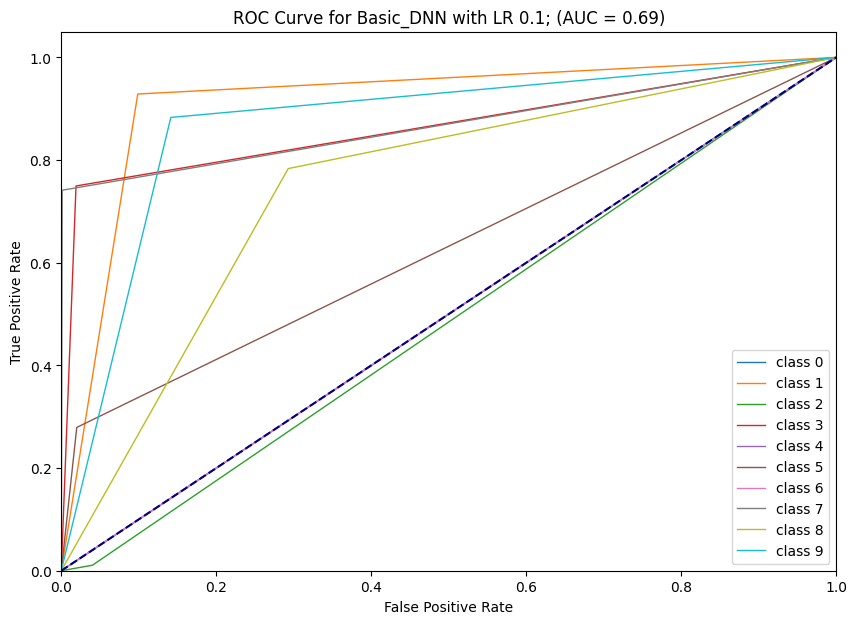

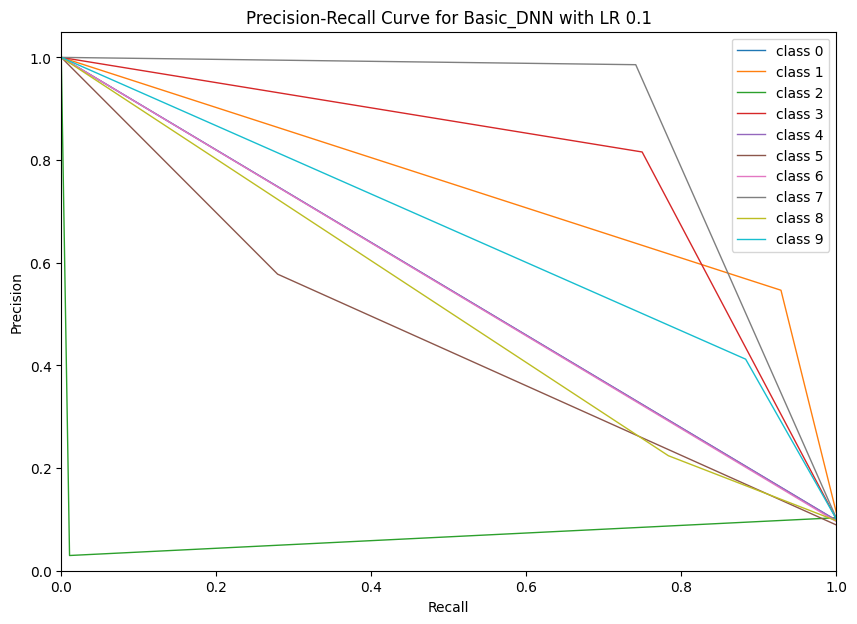


Learning Rate: 0.01
Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.5109 - f1_score: 0.4641 - loss: 1.2119 - val_accuracy: 0.5491 - val_f1_score: 0.4765 - val_loss: 1.1179
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5442 - f1_score: 0.4981 - loss: 1.1084 - val_accuracy: 0.5617 - val_f1_score: 0.4840 - val_loss: 1.0722
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.5532 - f1_score: 0.5042 - loss: 1.0722 - val_accuracy: 0.5708 - val_f1_score: 0.4949 - val_loss: 1.0542
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5779 - f1_score: 0.5423 - loss: 1.0365 - val_accuracy: 0.6572 - val_f1_score: 0.6153 - val_loss: 0.9494
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.6485 - f1_score: 0.6384 - loss: 0.9274 - val_accuracy: 0.6636 - val_f1_score: 0.6230 - val_loss: 0.9208
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.6588 - f1_score: 0.6484 - loss: 0.9017 - val_accuracy: 0.6732 -

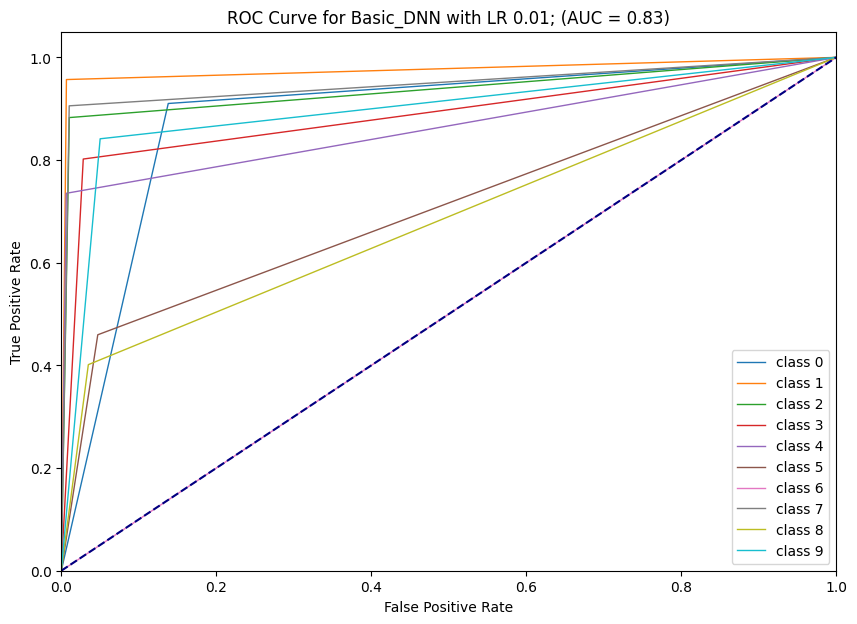

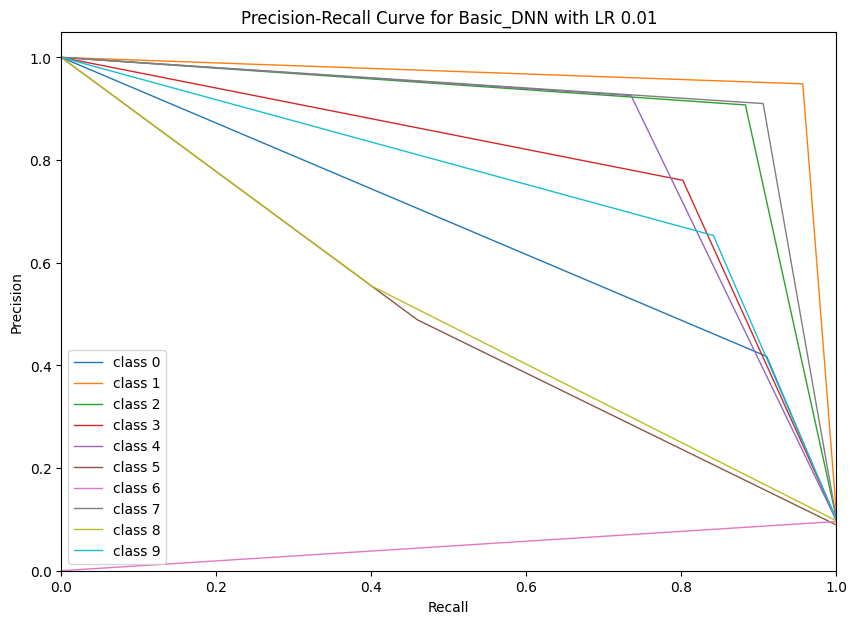


Learning Rate: 0.004
Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.7009 - f1_score: 0.6985 - loss: 0.7801 - val_accuracy: 0.7013 - val_f1_score: 0.6701 - val_loss: 0.7639
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.6999 - f1_score: 0.6987 - loss: 0.7703 - val_accuracy: 0.7102 - val_f1_score: 0.6803 - val_loss: 0.7497
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.7042 - f1_score: 0.7026 - loss: 0.7597 - val_accuracy: 0.7102 - val_f1_score: 0.6797 - val_loss: 0.7472
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.7066 - f1_score: 0.7051 - loss: 0.7524 - val_accuracy: 0.7106 - val_f1_score: 0.6805 - val_loss: 0.7429
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.7075 - f1_score: 0.7062 - loss: 0.7497 - val_accuracy: 0.7099 - val_f1_score: 0.6796 - val_loss: 0.7420
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.7087 - f1_score: 0.7075 - loss: 0.7443 - val_accuracy: 0.7097 

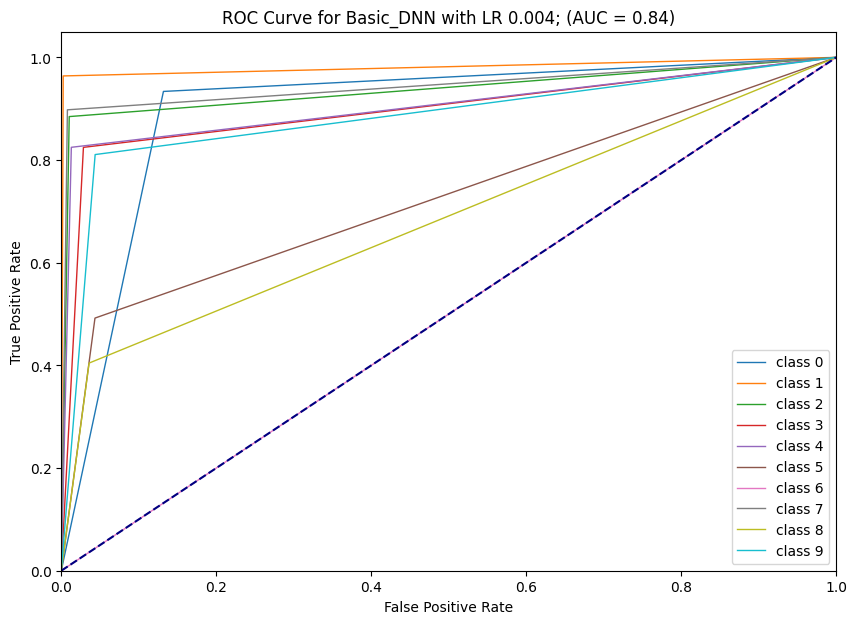

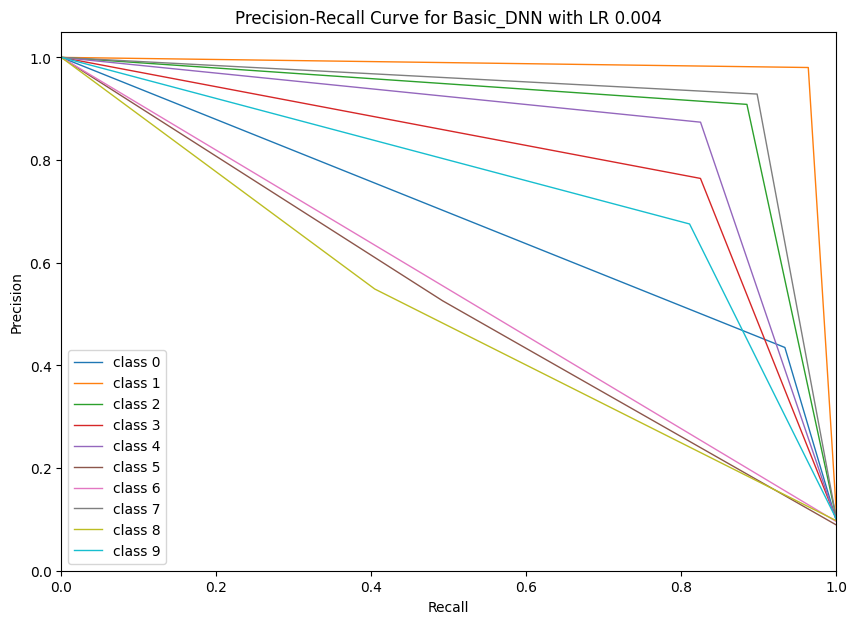


Training Basic_ConvNet

Learning Rate: 0.1
Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 12s 17ms/step - accuracy: 0.1051 - f1_score: 0.2944 - loss: 4.7407 - val_accuracy: 0.1028 - val_f1_score: 0.0192 - val_loss: 2.3052
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.1037 - f1_score: 0.0785 - loss: 2.3073 - val_accuracy: 0.1028 - val_f1_score: 0.0192 - val_loss: 2.3054
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.1034 - f1_score: 0.0802 - loss: 2.3076 - val_accuracy: 0.1028 - val_f1_score: 0.0192 - val_loss: 2.3056
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.1032 - f1_score: 0.0803 - loss: 2.3078 - val_accuracy: 0.1028 - val_f1_score: 0.0192 - val_loss: 2.3057
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.1031 - f1_score: 0.0803 - loss: 2.3078 - val_accuracy: 0.1028 - val_f1_score: 0.0192 - val_loss: 2.3058
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - accuracy: 0.1029 - f1_score: 0.0801 - loss: 

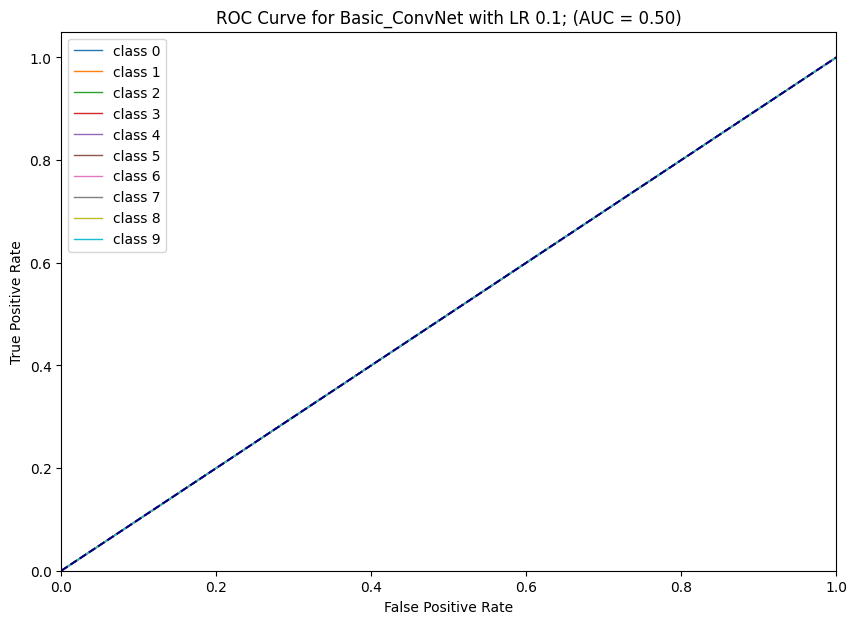

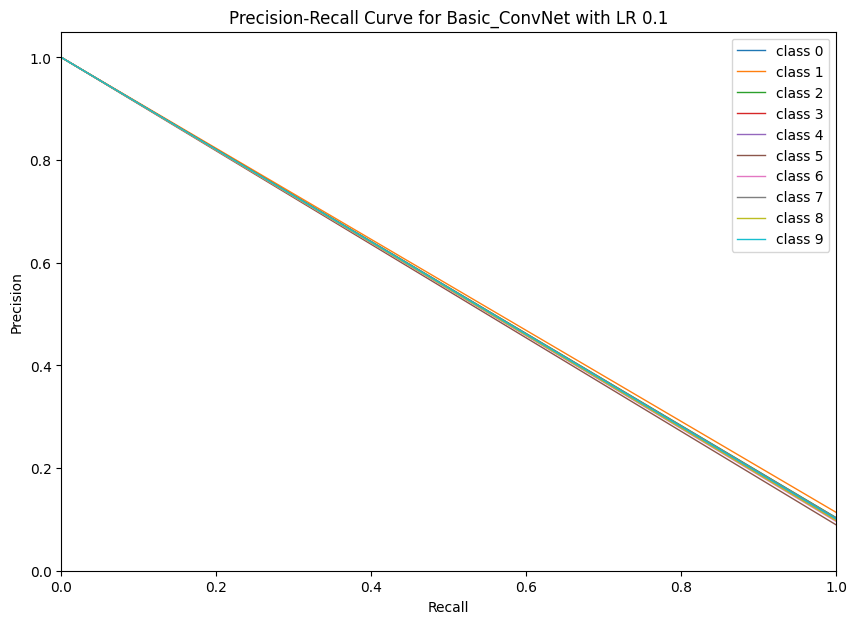


Learning Rate: 0.01
Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.1078 - f1_score: 0.0414 - loss: 2.3027 - val_accuracy: 0.1135 - val_f1_score: 0.0231 - val_loss: 2.3016
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.1113 - f1_score: 0.0308 - loss: 2.3018 - val_accuracy: 0.1135 - val_f1_score: 0.0231 - val_loss: 2.3016
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.1113 - f1_score: 0.0308 - loss: 2.3018 - val_accuracy: 0.1135 - val_f1_score: 0.0231 - val_loss: 2.3016
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.1113 - f1_score: 0.0308 - loss: 2.3018 - val_accuracy: 0.1135 - val_f1_score: 0.0231 - val_loss: 2.3016
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.1111 - f1_score: 0.0310 - loss: 2.3018 - val_accuracy: 0.1135 - val_f1_score: 0.0231 - val_loss: 2.3016
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.1111 - f1_score: 0.0310 - loss: 2.3018 - val_accuracy: 0

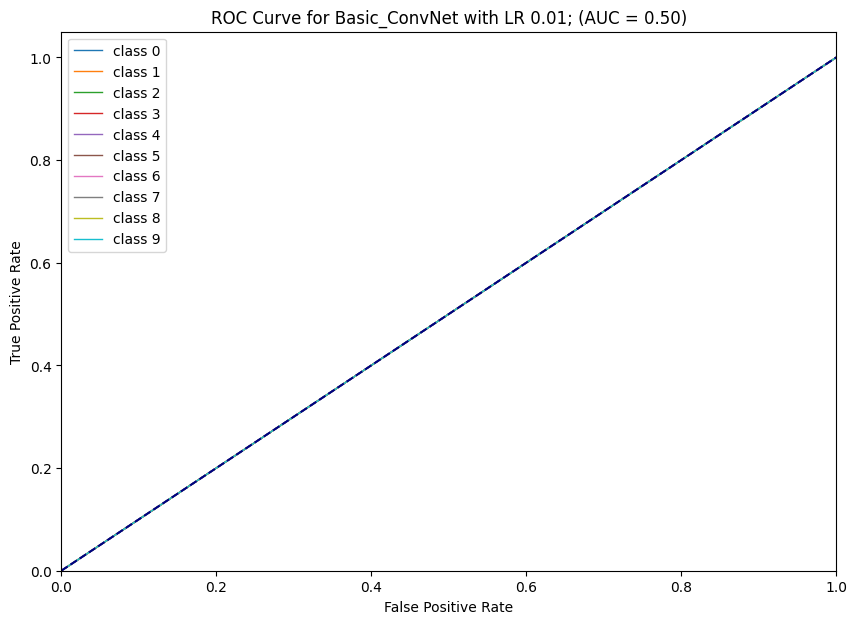

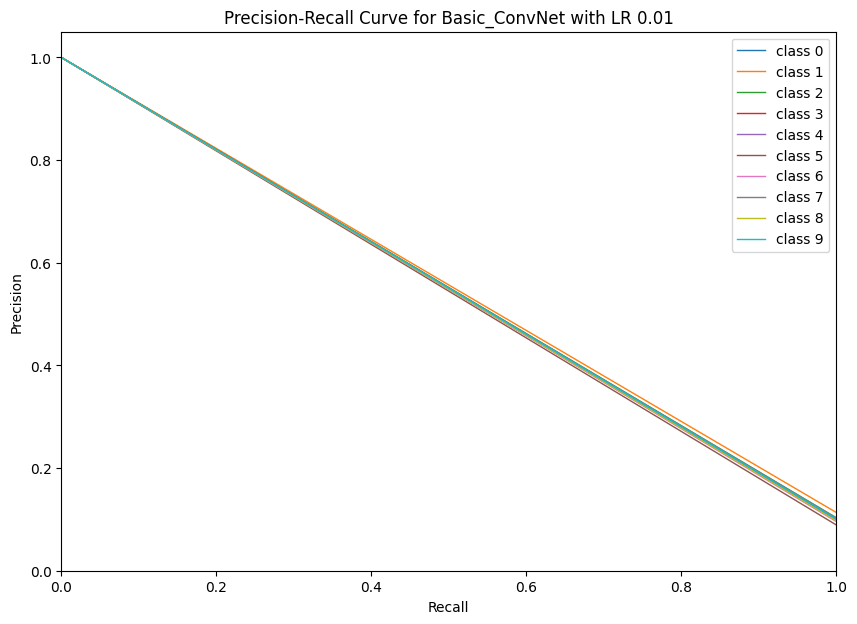


Learning Rate: 0.004
Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.1127 - f1_score: 0.0230 - loss: 2.3016 - val_accuracy: 0.1135 - val_f1_score: 0.0231 - val_loss: 2.3012
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.1127 - f1_score: 0.0228 - loss: 2.3016 - val_accuracy: 0.1135 - val_f1_score: 0.0231 - val_loss: 2.3012
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.1127 - f1_score: 0.0228 - loss: 2.3016 - val_accuracy: 0.1135 - val_f1_score: 0.0231 - val_loss: 2.3012
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.1127 - f1_score: 0.0228 - loss: 2.3016 - val_accuracy: 0.1135 - val_f1_score: 0.0231 - val_loss: 2.3012
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.1127 - f1_score: 0.0228 - loss: 2.3016 - val_accuracy: 0.1135 - val_f1_score: 0.0231 - val_loss: 2.3012
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.1127 - f1_score: 0.0228 - loss: 2.3016 - val_accuracy: 

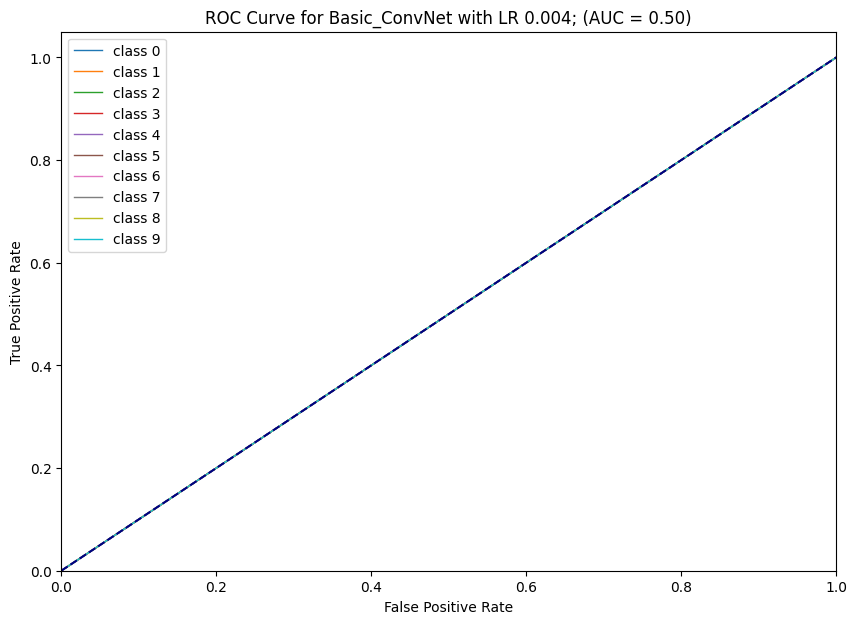

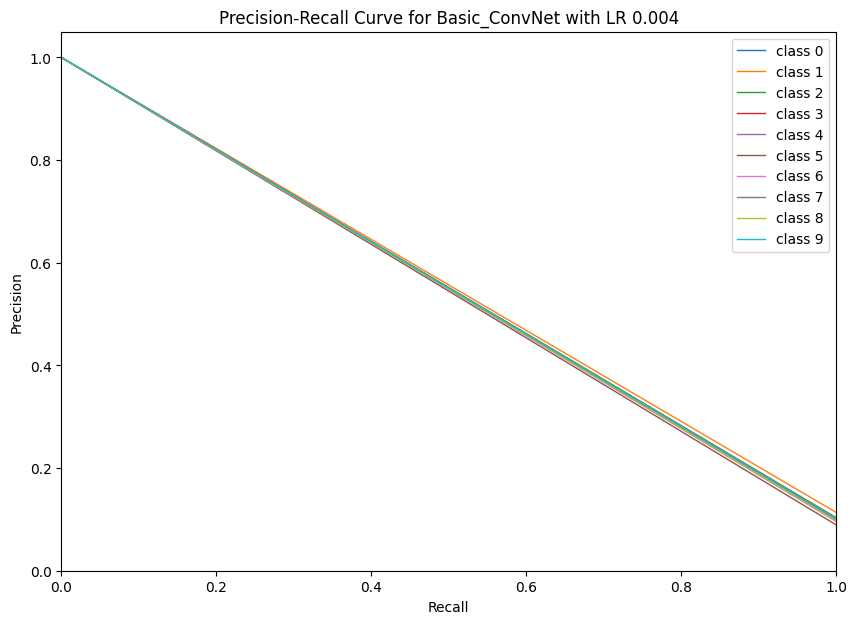


Training ResNet18

Learning Rate: 0.1
Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 76s 150ms/step - accuracy: 0.4415 - f1_score: 0.3380 - loss: 1.6924 - val_accuracy: 0.1480 - val_f1_score: 0.0804 - val_loss: 15.6724
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 70s 149ms/step - accuracy: 0.8589 - f1_score: 0.8585 - loss: 0.4234 - val_accuracy: 0.1839 - val_f1_score: 0.0806 - val_loss: 8.4088
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 71s 151ms/step - accuracy: 0.9142 - f1_score: 0.9143 - loss: 0.2697 - val_accuracy: 0.5895 - val_f1_score: 0.5675 - val_loss: 1.6058
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 71s 152ms/step - accuracy: 0.9336 - f1_score: 0.9337 - loss: 0.2125 - val_accuracy: 0.8794 - val_f1_score: 0.8783 - val_loss: 0.4176
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 72s 153ms/step - accuracy: 0.9448 - f1_score: 0.9448 - loss: 0.1784 - val_accuracy: 0.8648 - val_f1_score: 0.8630 - val_loss: 0.4541
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 72s 153ms/step - accuracy: 0.9502 - f1_score: 0.9502 - 

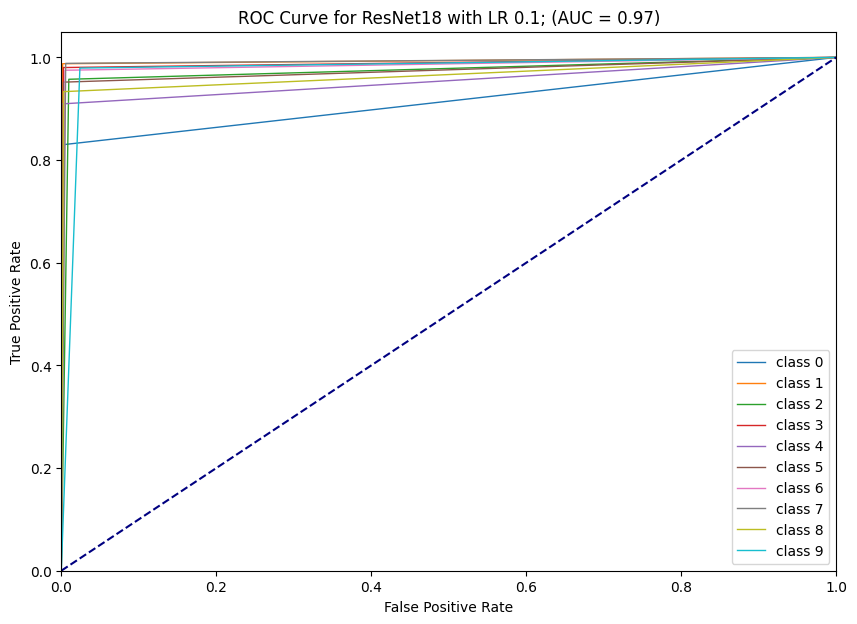

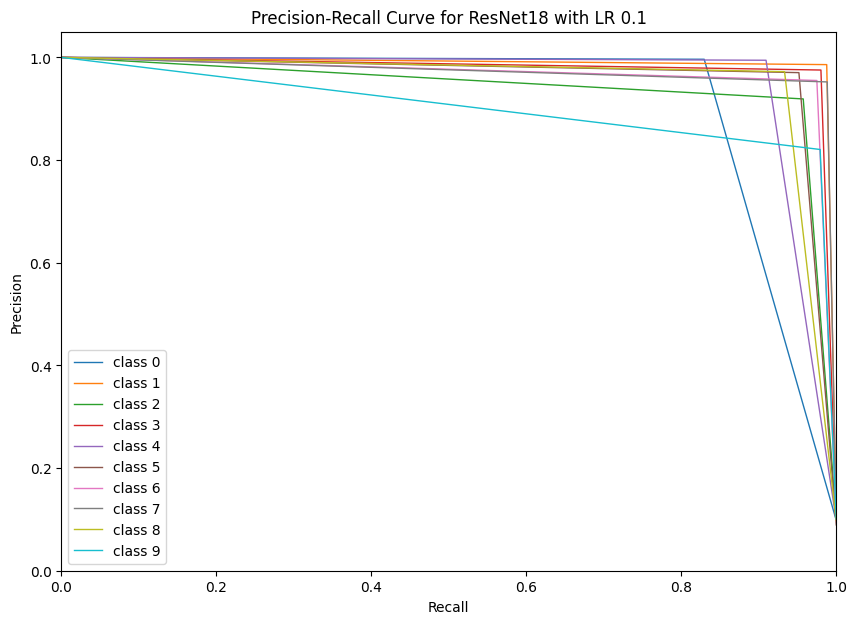


Learning Rate: 0.01
Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 76s 152ms/step - accuracy: 0.9779 - f1_score: 0.9690 - loss: 0.0765 - val_accuracy: 0.9777 - val_f1_score: 0.9777 - val_loss: 0.0789
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 70s 149ms/step - accuracy: 0.9802 - f1_score: 0.9803 - loss: 0.0672 - val_accuracy: 0.9795 - val_f1_score: 0.9795 - val_loss: 0.0747
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 71s 152ms/step - accuracy: 0.9809 - f1_score: 0.9809 - loss: 0.0638 - val_accuracy: 0.9802 - val_f1_score: 0.9802 - val_loss: 0.0737
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 72s 153ms/step - accuracy: 0.9816 - f1_score: 0.9816 - loss: 0.0616 - val_accuracy: 0.9796 - val_f1_score: 0.9796 - val_loss: 0.0738
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 70s 149ms/step - accuracy: 0.9821 - f1_score: 0.9821 - loss: 0.0597 - val_accuracy: 0.9794 - val_f1_score: 0.9794 - val_loss: 0.0716
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 71s 152ms/step - accuracy: 0.9827 - f1_score: 0.9827 - loss: 0.0580 - val_

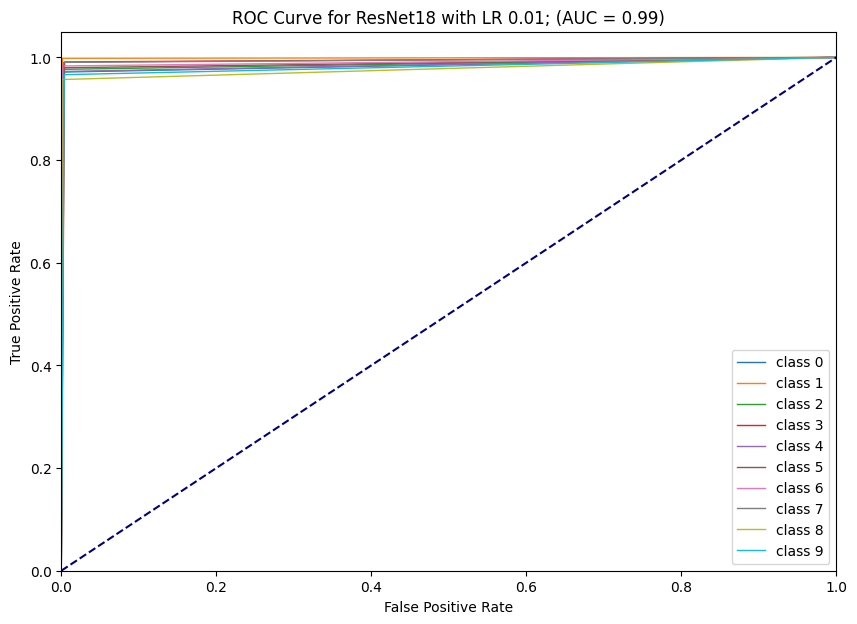

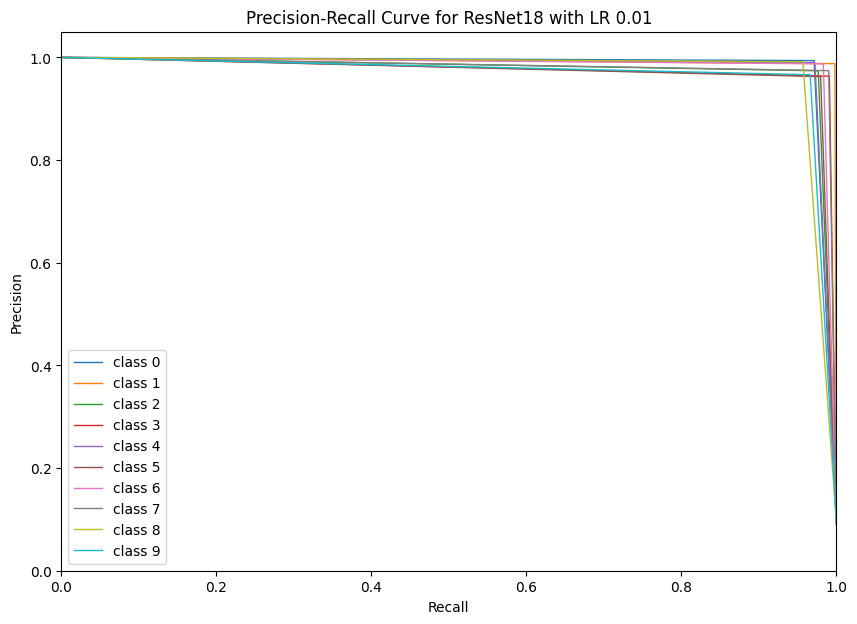


Learning Rate: 0.004
Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 76s 148ms/step - accuracy: 0.9854 - f1_score: 0.9833 - loss: 0.0484 - val_accuracy: 0.9827 - val_f1_score: 0.9827 - val_loss: 0.0587
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 71s 152ms/step - accuracy: 0.9860 - f1_score: 0.9860 - loss: 0.0468 - val_accuracy: 0.9828 - val_f1_score: 0.9828 - val_loss: 0.0583
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 80s 148ms/step - accuracy: 0.9863 - f1_score: 0.9863 - loss: 0.0462 - val_accuracy: 0.9829 - val_f1_score: 0.9829 - val_loss: 0.0583
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 70s 149ms/step - accuracy: 0.9866 - f1_score: 0.9866 - loss: 0.0458 - val_accuracy: 0.9830 - val_f1_score: 0.9830 - val_loss: 0.0576
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 71s 152ms/step - accuracy: 0.9865 - f1_score: 0.9865 - loss: 0.0453 - val_accuracy: 0.9833 - val_f1_score: 0.9833 - val_loss: 0.0577
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 72s 154ms/step - accuracy: 0.9867 - f1_score: 0.9866 - loss: 0.0449 - val

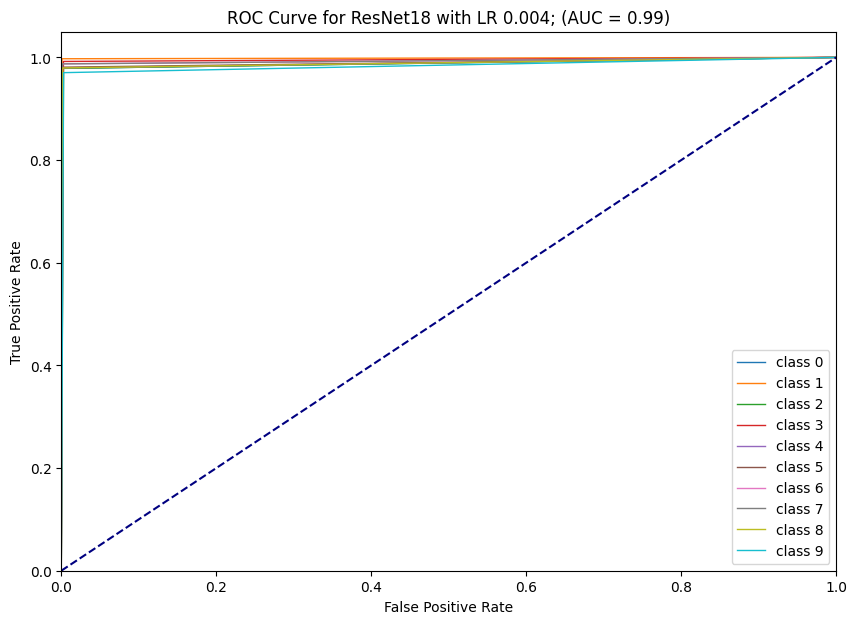

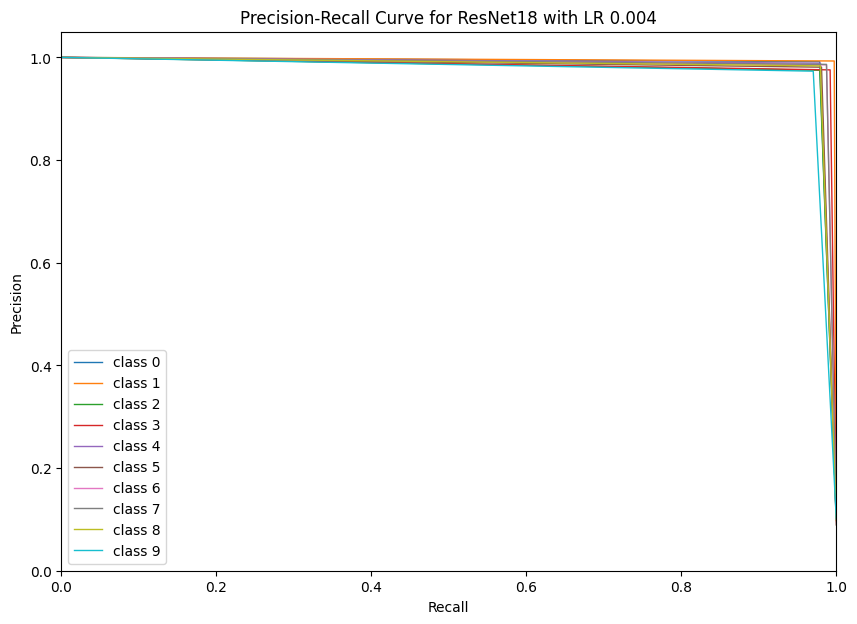


Training VGG_S

Learning Rate: 0.1
Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 106s 209ms/step - accuracy: 0.3336 - f1_score: 0.5670 - loss: 14.1261 - val_accuracy: 0.6501 - val_f1_score: 0.5955 - val_loss: 8.3338
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 97s 206ms/step - accuracy: 0.6279 - f1_score: 0.6269 - loss: 0.9582 - val_accuracy: 0.7501 - val_f1_score: 0.7237 - val_loss: 0.5990
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 98s 209ms/step - accuracy: 0.7925 - f1_score: 0.7915 - loss: 0.6230 - val_accuracy: 0.7830 - val_f1_score: 0.7729 - val_loss: 0.5369
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 98s 209ms/step - accuracy: 0.8796 - f1_score: 0.8796 - loss: 0.4310 - val_accuracy: 0.9545 - val_f1_score: 0.9546 - val_loss: 0.1749
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 97s 207ms/step - accuracy: 0.5776 - f1_score: 0.5783 - loss: 1.4757 - val_accuracy: 0.1028 - val_f1_score: 0.0192 - val_loss: 2.3058
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 97s 206ms/step - accuracy: 0.1045 - f1_score: 0.0776 - lo

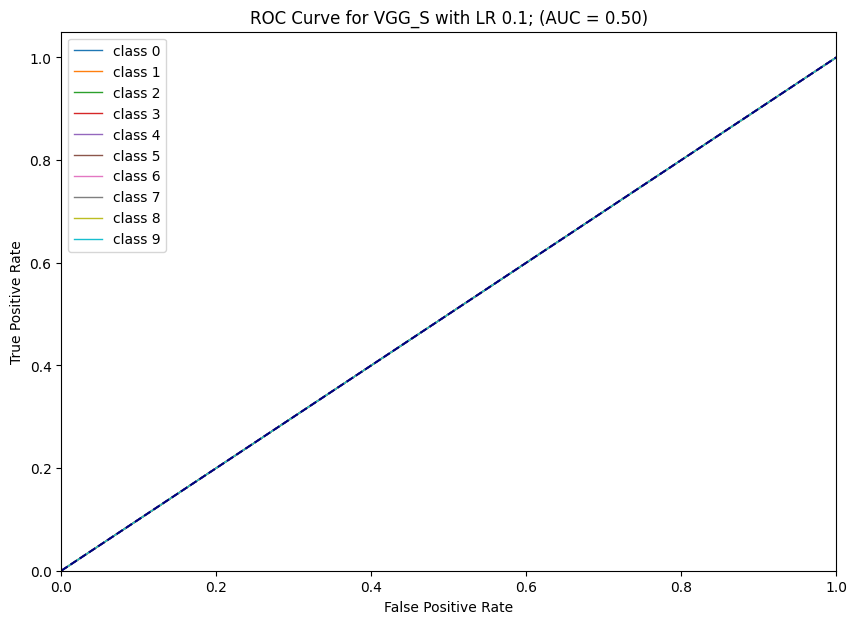

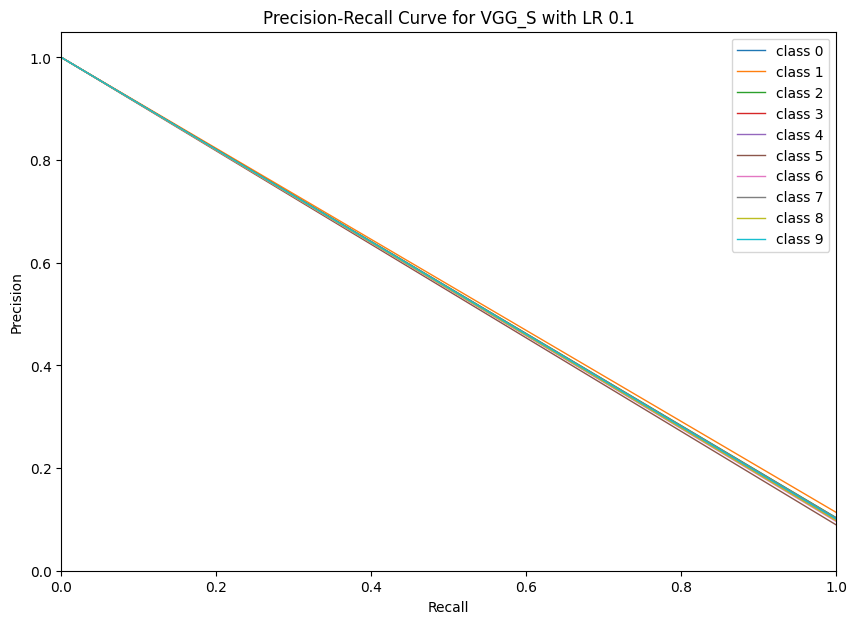


Learning Rate: 0.01
Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 111s 221ms/step - accuracy: 0.1078 - f1_score: 0.0414 - loss: 2.3027 - val_accuracy: 0.1135 - val_f1_score: 0.0231 - val_loss: 2.3016
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 102s 218ms/step - accuracy: 0.1113 - f1_score: 0.0308 - loss: 2.3018 - val_accuracy: 0.1135 - val_f1_score: 0.0231 - val_loss: 2.3016
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 103s 219ms/step - accuracy: 0.1113 - f1_score: 0.0308 - loss: 2.3018 - val_accuracy: 0.1135 - val_f1_score: 0.0231 - val_loss: 2.3016
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 98s 209ms/step - accuracy: 0.1113 - f1_score: 0.0308 - loss: 2.3018 - val_accuracy: 0.1135 - val_f1_score: 0.0231 - val_loss: 2.3016
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 97s 207ms/step - accuracy: 0.1111 - f1_score: 0.0310 - loss: 2.3018 - val_accuracy: 0.1135 - val_f1_score: 0.0231 - val_loss: 2.3016
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 97s 207ms/step - accuracy: 0.1111 - f1_score: 0.0310 - loss: 2.3018 - v

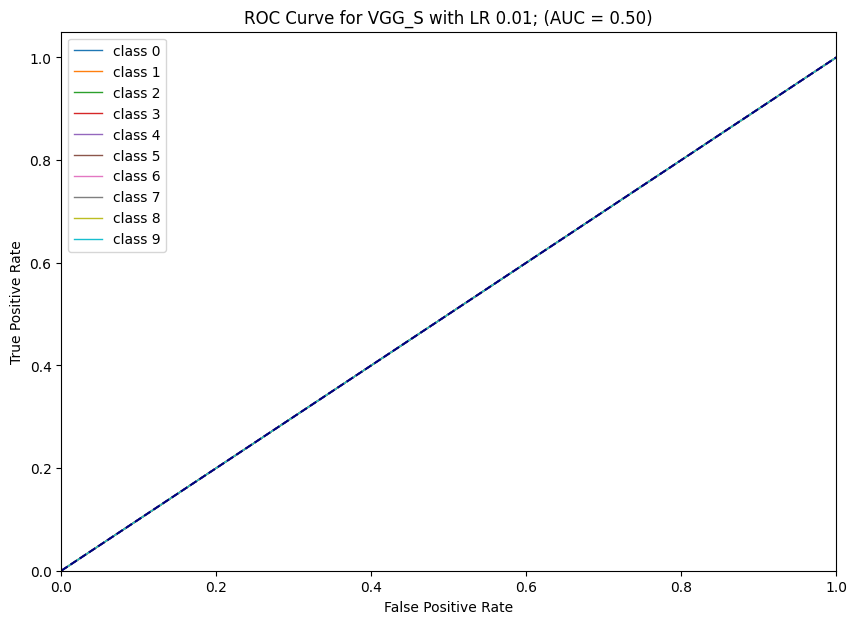

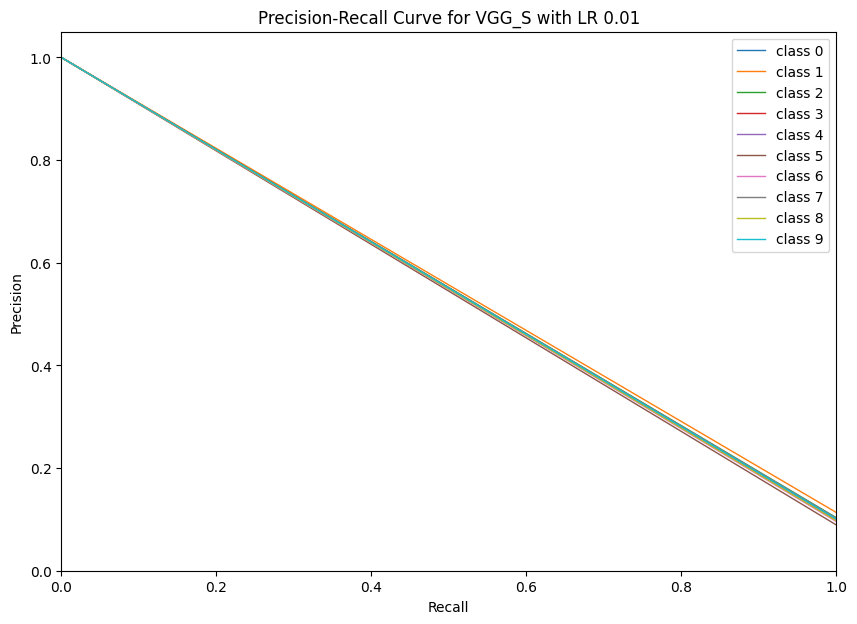


Learning Rate: 0.004
Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 106s 209ms/step - accuracy: 0.1127 - f1_score: 0.0230 - loss: 2.3016 - val_accuracy: 0.1135 - val_f1_score: 0.0231 - val_loss: 2.3012
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 99s 210ms/step - accuracy: 0.1127 - f1_score: 0.0228 - loss: 2.3016 - val_accuracy: 0.1135 - val_f1_score: 0.0231 - val_loss: 2.3012
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 98s 208ms/step - accuracy: 0.1127 - f1_score: 0.0228 - loss: 2.3016 - val_accuracy: 0.1135 - val_f1_score: 0.0231 - val_loss: 2.3012
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 97s 208ms/step - accuracy: 0.1127 - f1_score: 0.0228 - loss: 2.3016 - val_accuracy: 0.1135 - val_f1_score: 0.0231 - val_loss: 2.3012
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 99s 211ms/step - accuracy: 0.1127 - f1_score: 0.0228 - loss: 2.3016 - val_accuracy: 0.1135 - val_f1_score: 0.0231 - val_loss: 2.3012
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 98s 209ms/step - accuracy: 0.1127 - f1_score: 0.0228 - loss: 2.3016 - va

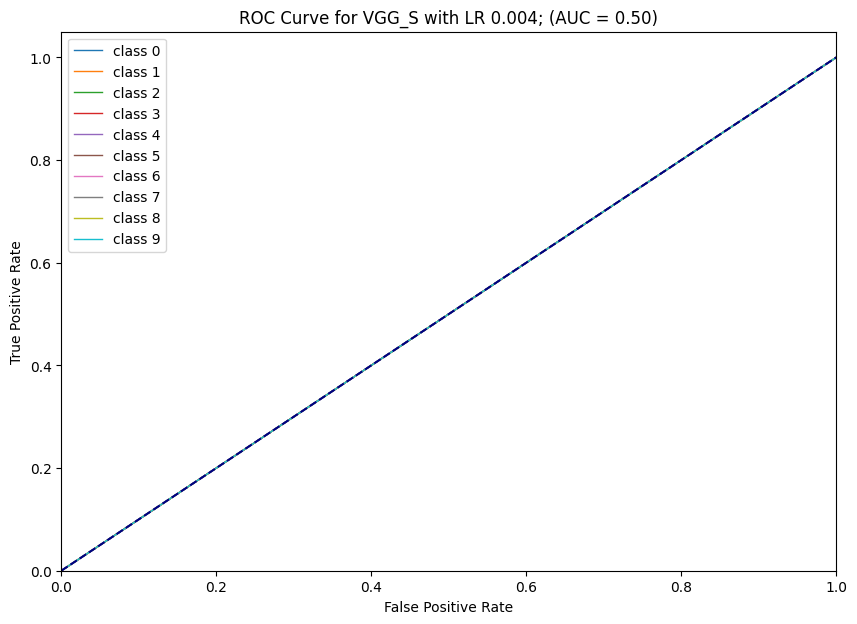

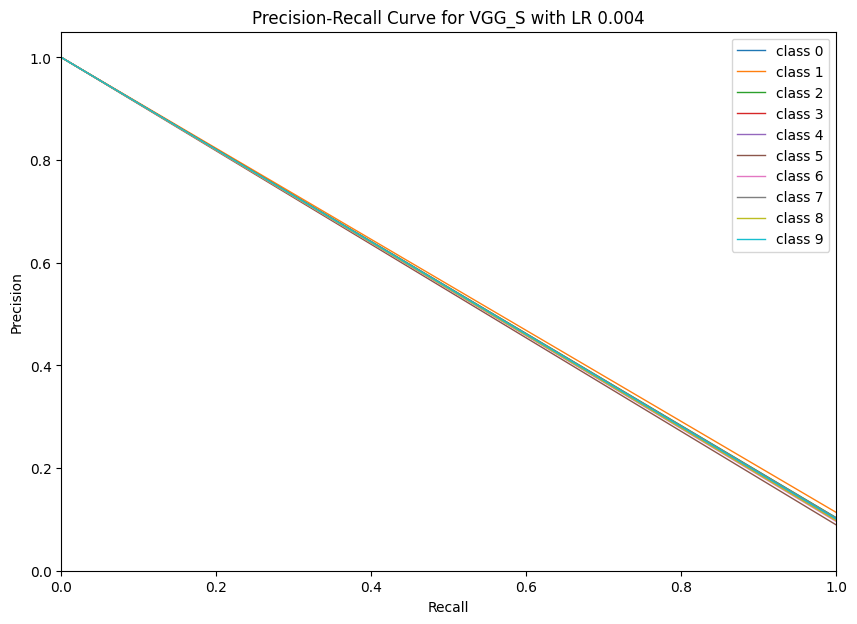

In [102]:
(x_train, y_train), (x_test, y_test) = load_preprocess_data()

input_shape = x_train.shape[1:]
print(input_shape)
num_classes = 10

# Main training
# Define models
models_dict = {
    'Basic_DNN': build_basic_dnn(input_shape, num_classes),
    'Basic_ConvNet': build_basic_convnet(input_shape, num_classes),
    'ResNet18': build_resnet18(input_shape, num_classes),
    'VGG_S': build_vgg_s(input_shape, num_classes)
}

# Define learning rates
learning_rates = [0.1, 0.01, 0.004]

# Dictionaries to store metrics
history_dict = defaultdict(dict)
roc_auc_dict = defaultdict(dict)
pr_auc_dict = defaultdict(dict)

for model_name, model in models_dict.items():
    print(f'\n{"="*50}\nTraining {model_name}\n{"="*50}')
    for lr in learning_rates:
        print(f'\nLearning Rate: {lr}')
        # Compile model
        optimizer = optimizers.Adam(learning_rate=lr)
        model.compile(optimizer=optimizer,
                      loss='categorical_crossentropy',
                      metrics=['accuracy',f1_metric])

        # Train model
        history = model.fit(x_train, y_train,
                            epochs=10,
                            batch_size=128,
                            validation_data=(x_val, y_val),
                            callbacks=[EarlyStopping(patience=5, monitor='f1_score')],
                            verbose=1)

        # Save metrics
        history_dict[model_name][lr] = {
            'accuracy': history.history['accuracy'],
            'val_accuracy': history.history['val_accuracy'],
            'loss': history.history['loss'],
            'val_loss': history.history['val_loss'],
            'f1_score': history.history['f1_score'],
            'val_f1_score': history.history['val_f1_score']
        }

        # Save model weights
        path = f'trained_models/{model_name}_lr_{lr}.keras'
        model.save(path)
        print(f'Model saved to {weight_path}')
        
        y_pred_proba = model.predict(x_val)
        y_pred = (y_pred_proba == y_pred_proba.max(axis=1)[:,None]).astype(int)
        # Plot combined ROC curves
        plot_combined_roc(y_test, y_pred, model_name, lr)

        # Plot combined Precision-Recall curves
        plot_combined_precision_recall(y_test, y_pred, model_name, lr)

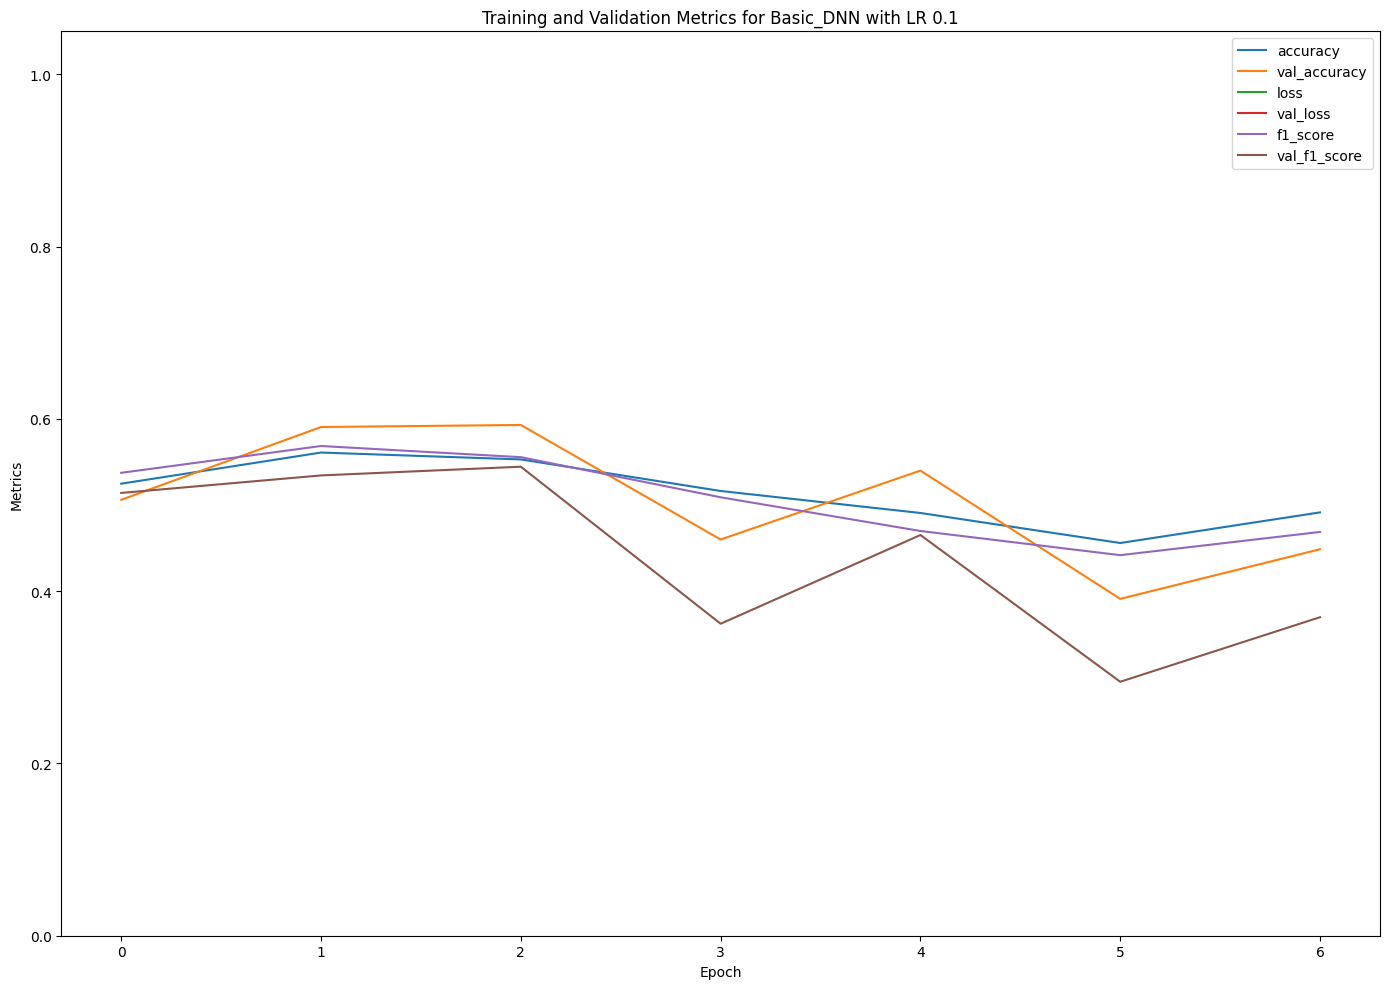

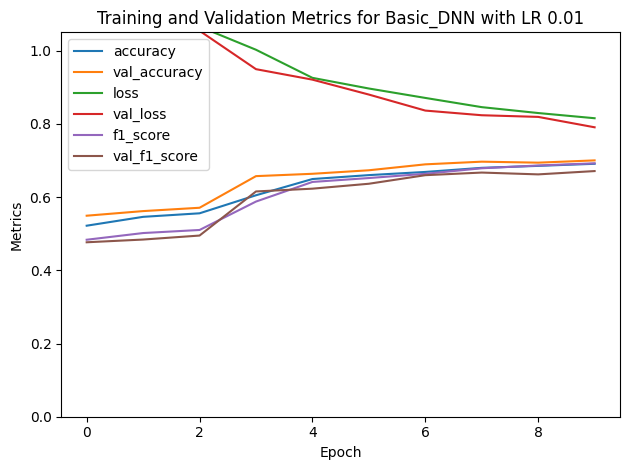

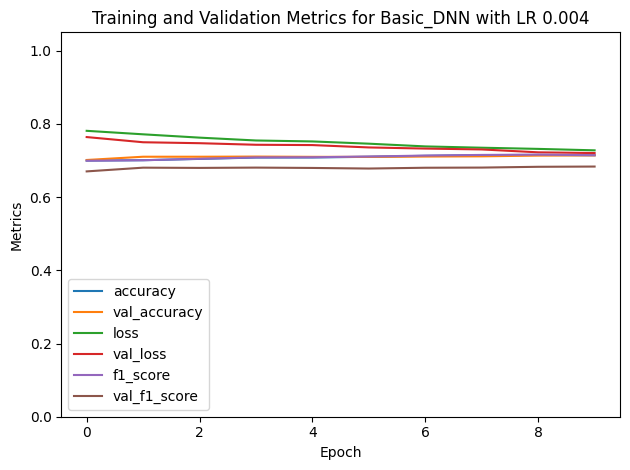

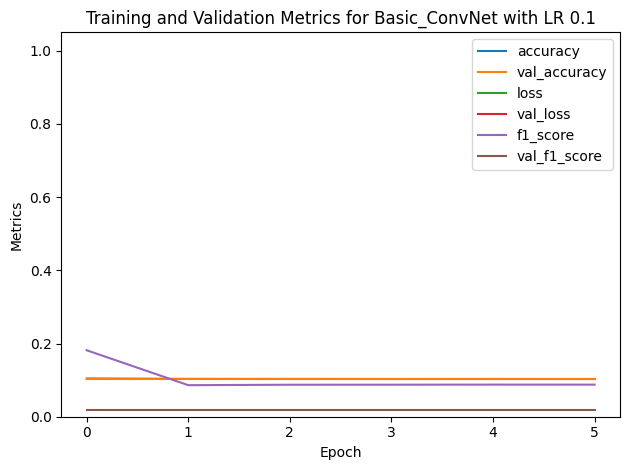

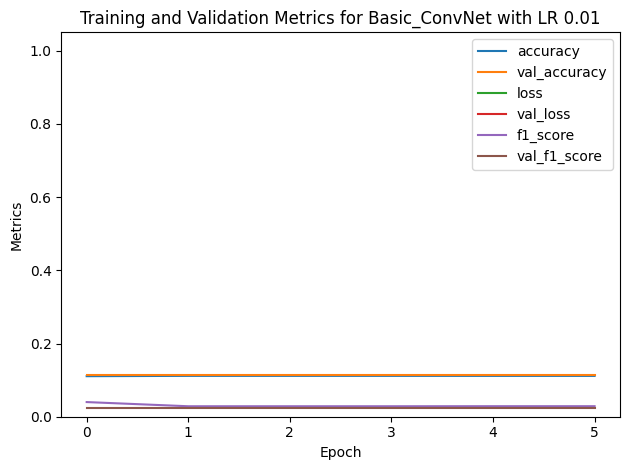

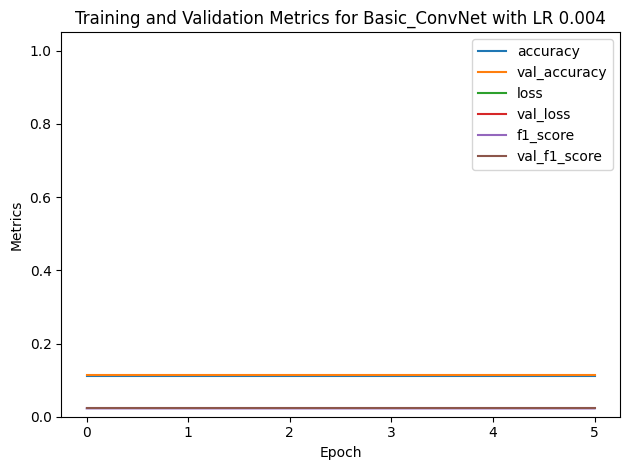

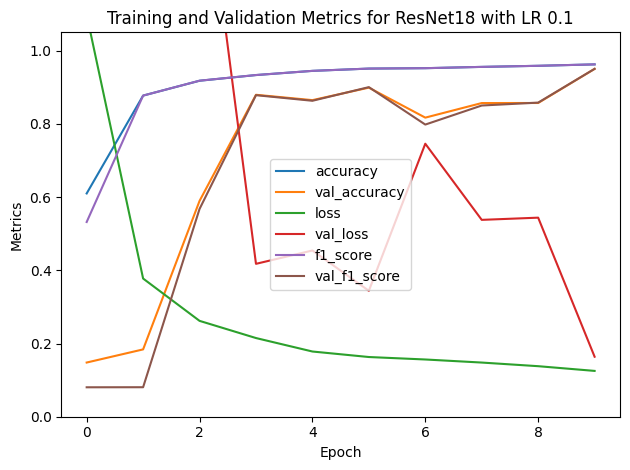

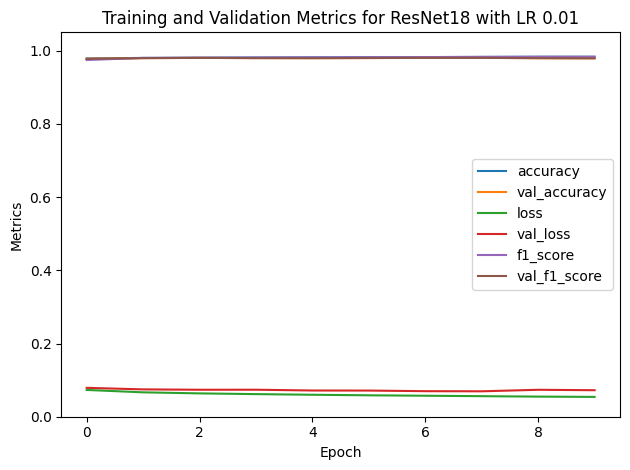

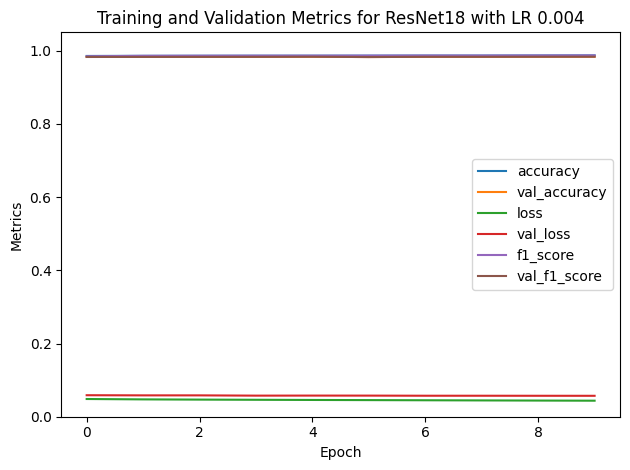

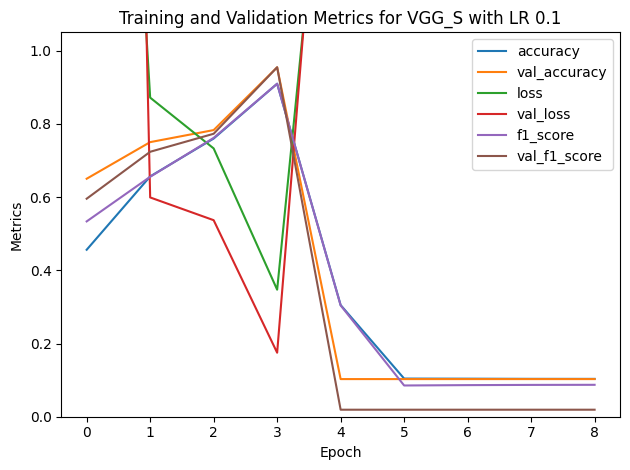

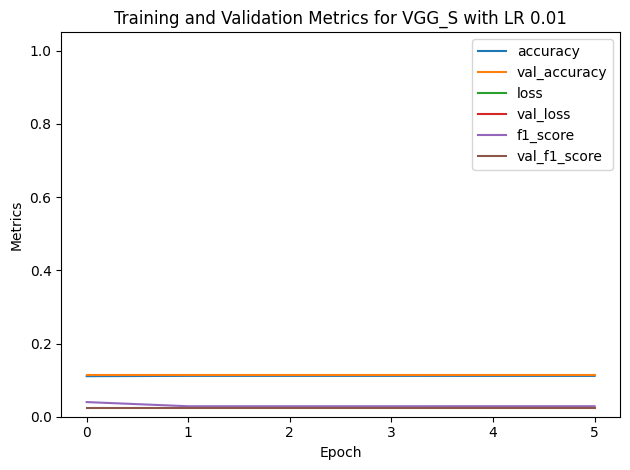

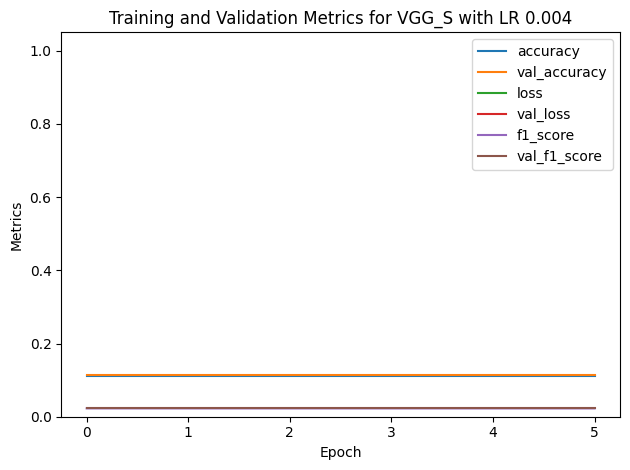

In [103]:
# Plot Accuracy, Loss, F1 Score
plot_accuracies(history_dict)


Training Basic_DNN

Learning Rate: 0.1
Epoch 1/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.1089 - f1_score: 0.0859 - loss: 252.7441 - val_accuracy: 0.1123 - val_f1_score: 0.0227 - val_loss: 2.3069
Epoch 2/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.1015 - f1_score: 0.0820 - loss: 2.3088 - val_accuracy: 0.1061 - val_f1_score: 0.0203 - val_loss: 2.3068
Epoch 3/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.1037 - f1_score: 0.0822 - loss: 2.3087 - val_accuracy: 0.1061 - val_f1_score: 0.0203 - val_loss: 2.3071
Epoch 4/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.1037 - f1_score: 0.0826 - loss: 2.3089 - val_accuracy: 0.1061 - val_f1_score: 0.0203 - val_loss: 2.3073
Epoch 5/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.1035 - f1_score: 0.0823 - loss: 2.3089 - val_accuracy: 0.1061 - val_f1_score: 0.0203 - val_loss: 2.3073
Epoch 6/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.1036 - f1_score: 0.0823 - loss: 2.3089 - v

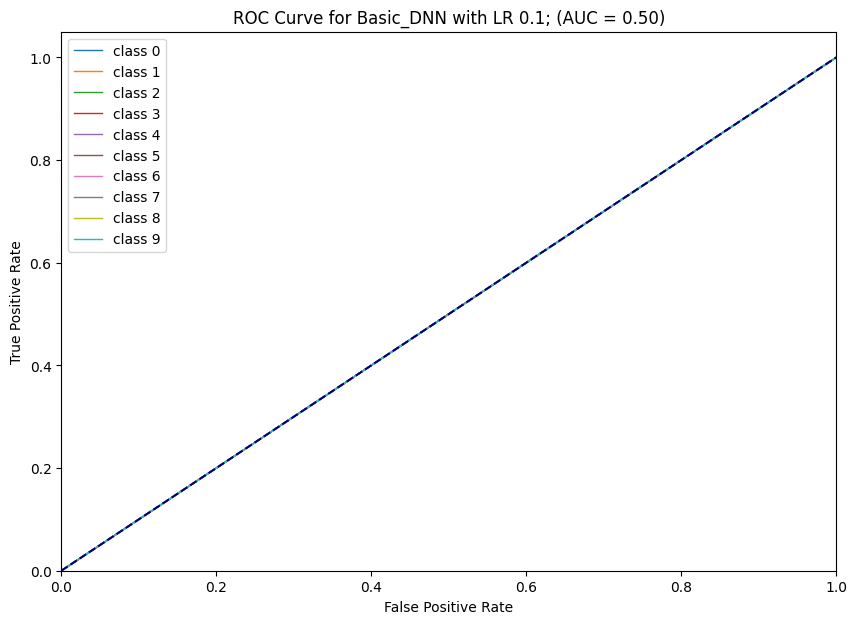

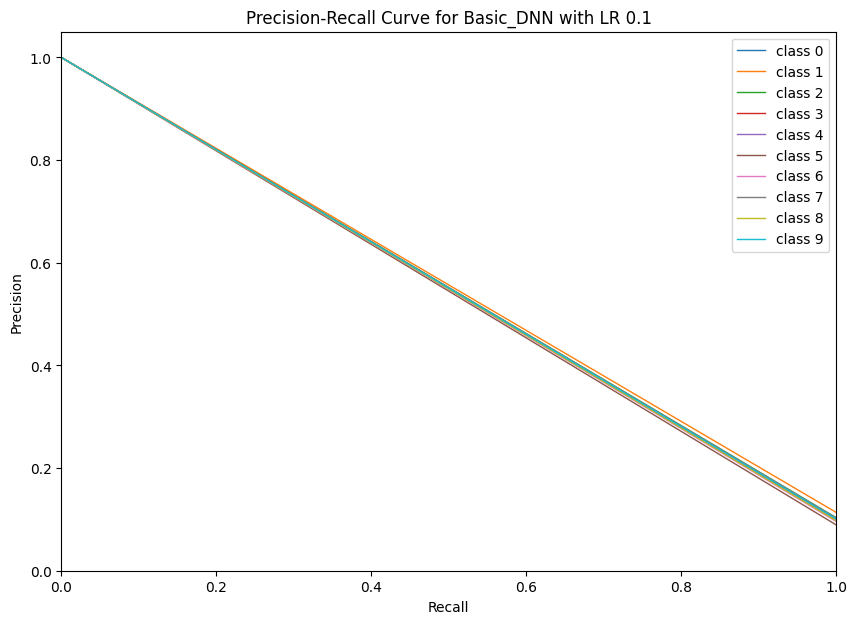


Learning Rate: 0.01
Epoch 1/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.1109 - f1_score: 0.0385 - loss: 2.3028 - val_accuracy: 0.1123 - val_f1_score: 0.0227 - val_loss: 2.3023
Epoch 2/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.1115 - f1_score: 0.0337 - loss: 2.3021 - val_accuracy: 0.1123 - val_f1_score: 0.0227 - val_loss: 2.3023
Epoch 3/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.1115 - f1_score: 0.0337 - loss: 2.3021 - val_accuracy: 0.1123 - val_f1_score: 0.0227 - val_loss: 2.3023
Epoch 4/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.1115 - f1_score: 0.0337 - loss: 2.3021 - val_accuracy: 0.1123 - val_f1_score: 0.0227 - val_loss: 2.3023
Epoch 5/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.1115 - f1_score: 0.0337 - loss: 2.3021 - val_accuracy: 0.1123 - val_f1_score: 0.0227 - val_loss: 2.3023
Epoch 6/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.1115 - f1_score: 0.0337 - loss: 2.3021 - val_accuracy: 0.1123 -

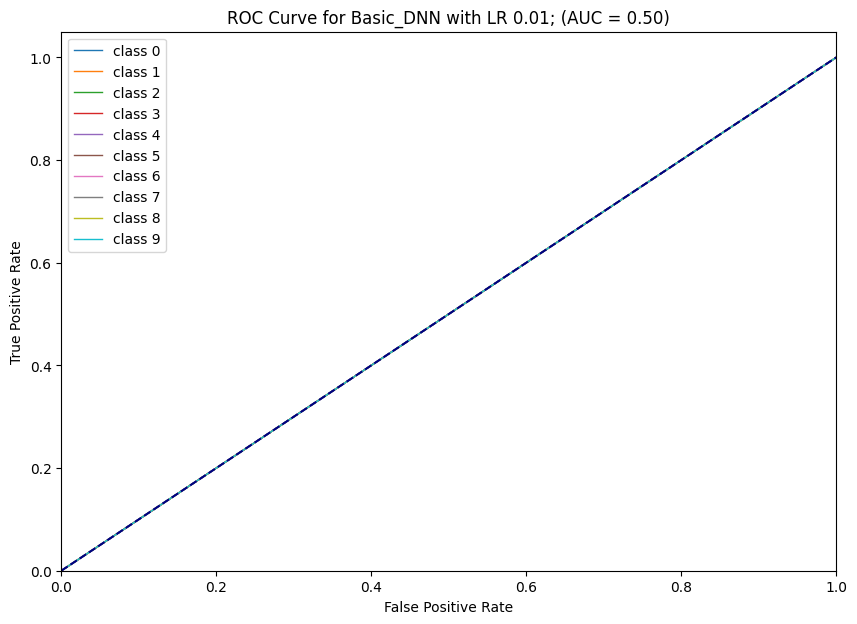

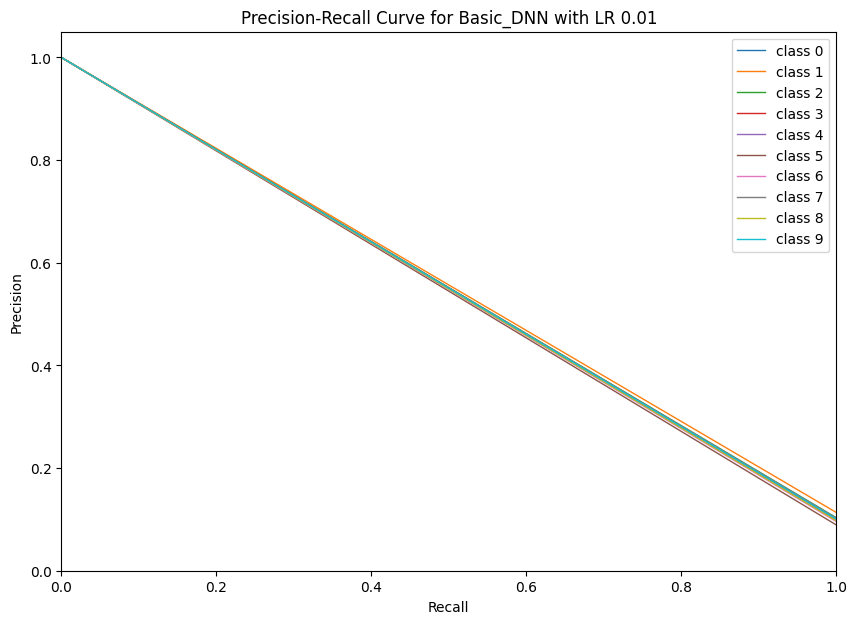


Learning Rate: 0.001
Epoch 1/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.1120 - f1_score: 0.0227 - loss: 2.3016 - val_accuracy: 0.1123 - val_f1_score: 0.0227 - val_loss: 2.3016
Epoch 2/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.1120 - f1_score: 0.0226 - loss: 2.3014 - val_accuracy: 0.1123 - val_f1_score: 0.0227 - val_loss: 2.3015
Epoch 3/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.1120 - f1_score: 0.0226 - loss: 2.3014 - val_accuracy: 0.1123 - val_f1_score: 0.0227 - val_loss: 2.3015
Epoch 4/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.1120 - f1_score: 0.0226 - loss: 2.3014 - val_accuracy: 0.1123 - val_f1_score: 0.0227 - val_loss: 2.3015
Epoch 5/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.1120 - f1_score: 0.0226 - loss: 2.3014 - val_accuracy: 0.1123 - val_f1_score: 0.0227 - val_loss: 2.3015
Epoch 6/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.1120 - f1_score: 0.0226 - loss: 2.3014 - val_accuracy: 0.1123 

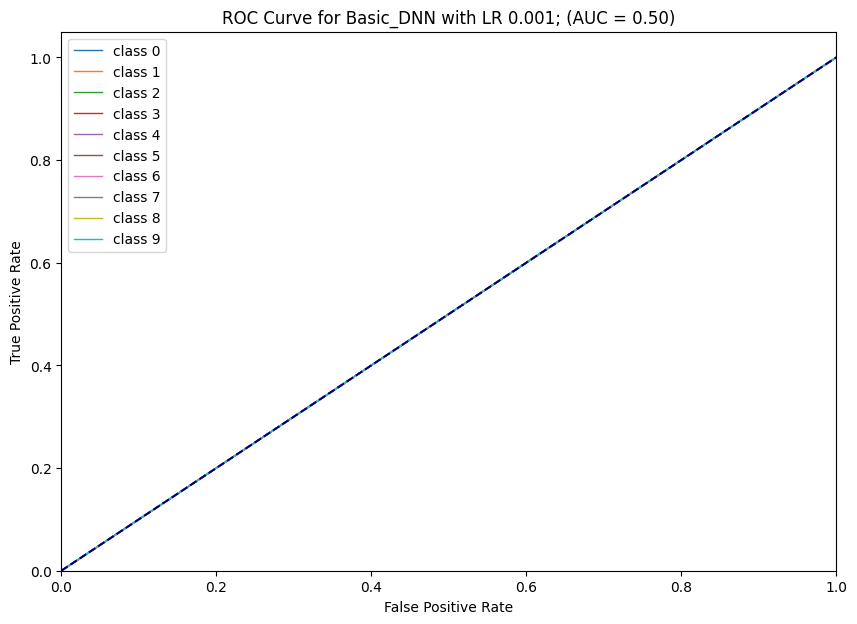

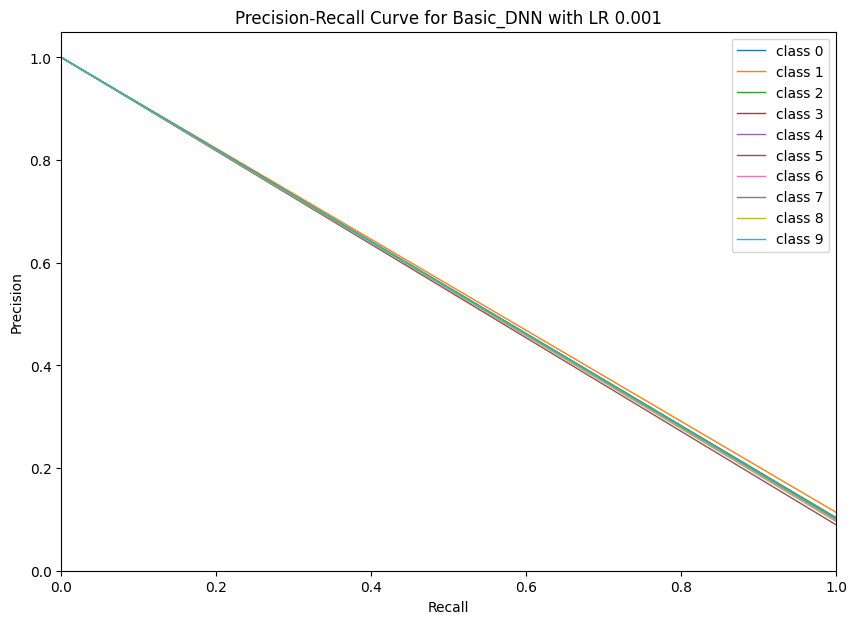


Training Basic_ConvNet

Learning Rate: 0.1
Epoch 1/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 50s 63ms/step - accuracy: 0.8779 - f1_score: 0.6202 - loss: 0.4435 - val_accuracy: 0.9446 - val_f1_score: 0.9453 - val_loss: 0.2855
Epoch 2/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.9524 - f1_score: 0.9524 - loss: 0.2734 - val_accuracy: 0.9102 - val_f1_score: 0.9149 - val_loss: 2.9792
Epoch 3/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - accuracy: 0.9612 - f1_score: 0.9612 - loss: 0.3314 - val_accuracy: 0.9716 - val_f1_score: 0.9716 - val_loss: 0.4383
Epoch 4/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - accuracy: 0.9727 - f1_score: 0.9727 - loss: 0.1897 - val_accuracy: 0.9712 - val_f1_score: 0.9713 - val_loss: 0.3473
Epoch 5/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - accuracy: 0.9694 - f1_score: 0.9694 - loss: 0.3278 - val_accuracy: 0.9747 - val_f1_score: 0.9746 - val_loss: 0.4611
Epoch 6/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - accuracy: 0.9729 - f1_score: 0.9729 - lo

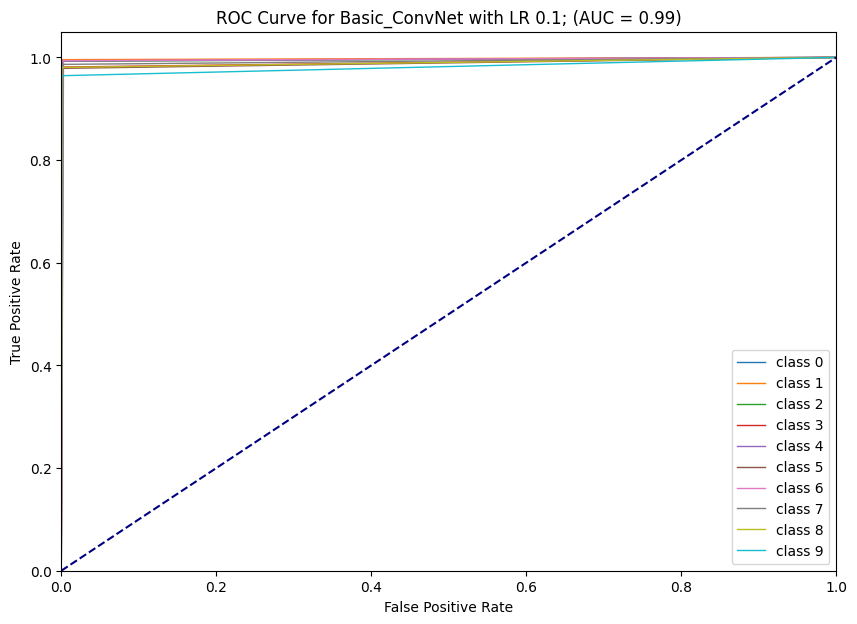

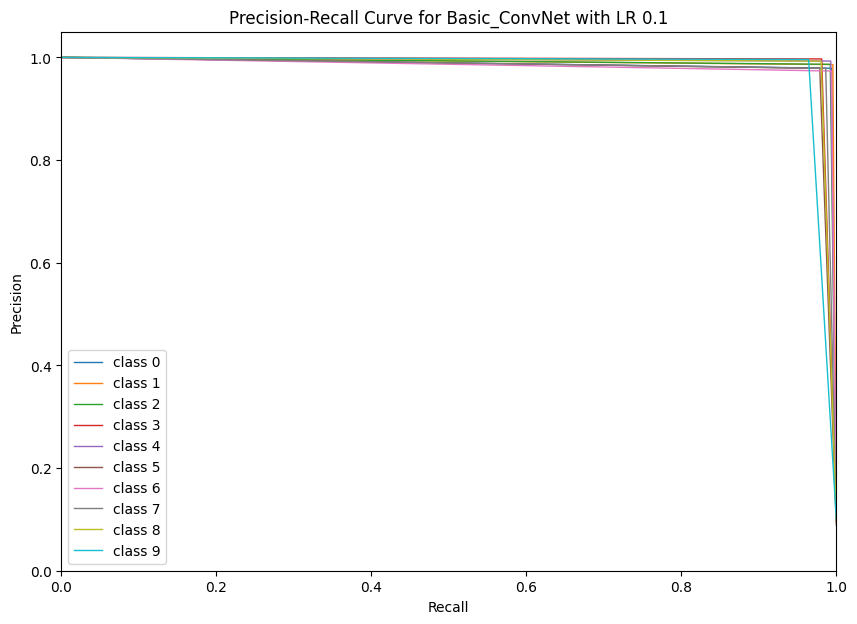


Learning Rate: 0.01
Epoch 1/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 16s 16ms/step - accuracy: 0.9906 - f1_score: 0.9880 - loss: 0.1388 - val_accuracy: 0.9899 - val_f1_score: 0.9899 - val_loss: 688.4092
Epoch 2/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.9930 - f1_score: 0.9930 - loss: 0.0739 - val_accuracy: 0.9911 - val_f1_score: 0.9911 - val_loss: 268.2703
Epoch 3/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.9946 - f1_score: 0.9946 - loss: 0.0427 - val_accuracy: 0.9909 - val_f1_score: 0.9909 - val_loss: 485.5831
Epoch 4/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.9949 - f1_score: 0.9949 - loss: 0.0332 - val_accuracy: 0.9903 - val_f1_score: 0.9903 - val_loss: 442.9467
Epoch 5/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.9947 - f1_score: 0.9947 - loss: 0.0272 - val_accuracy: 0.9902 - val_f1_score: 0.9903 - val_loss: 313.6623
Epoch 6/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.9950 - f1_score: 0.9950 - loss: 0.0217 - 

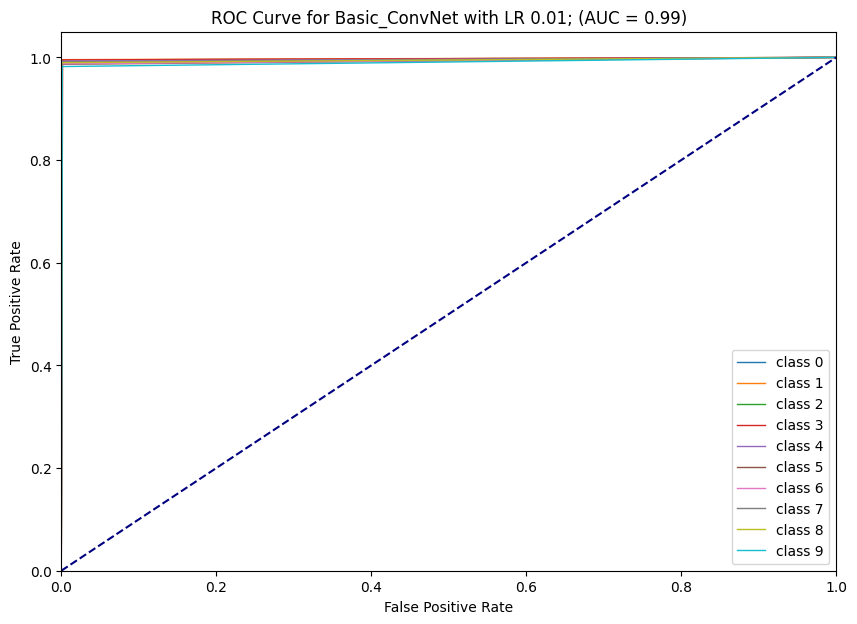

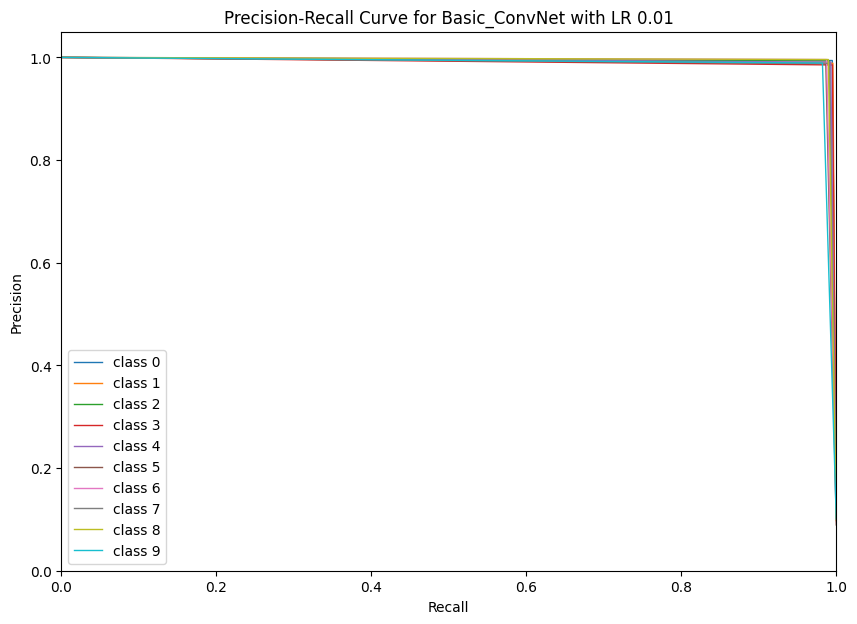


Learning Rate: 0.001
Epoch 1/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 16s 16ms/step - accuracy: 0.9971 - f1_score: 0.9947 - loss: 0.0131 - val_accuracy: 0.9910 - val_f1_score: 0.9910 - val_loss: 198.9340
Epoch 2/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.9974 - f1_score: 0.9974 - loss: 0.0116 - val_accuracy: 0.9914 - val_f1_score: 0.9914 - val_loss: 174.0352
Epoch 3/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 21s 15ms/step - accuracy: 0.9983 - f1_score: 0.9983 - loss: 0.0088 - val_accuracy: 0.9913 - val_f1_score: 0.9913 - val_loss: 153.3025
Epoch 4/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.9978 - f1_score: 0.9978 - loss: 0.0098 - val_accuracy: 0.9912 - val_f1_score: 0.9912 - val_loss: 136.9645
Epoch 5/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.9977 - f1_score: 0.9977 - loss: 0.0089 - val_accuracy: 0.9908 - val_f1_score: 0.9908 - val_loss: 133.8900
Epoch 6/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.9981 - f1_score: 0.9981 - loss: 0.0071 -

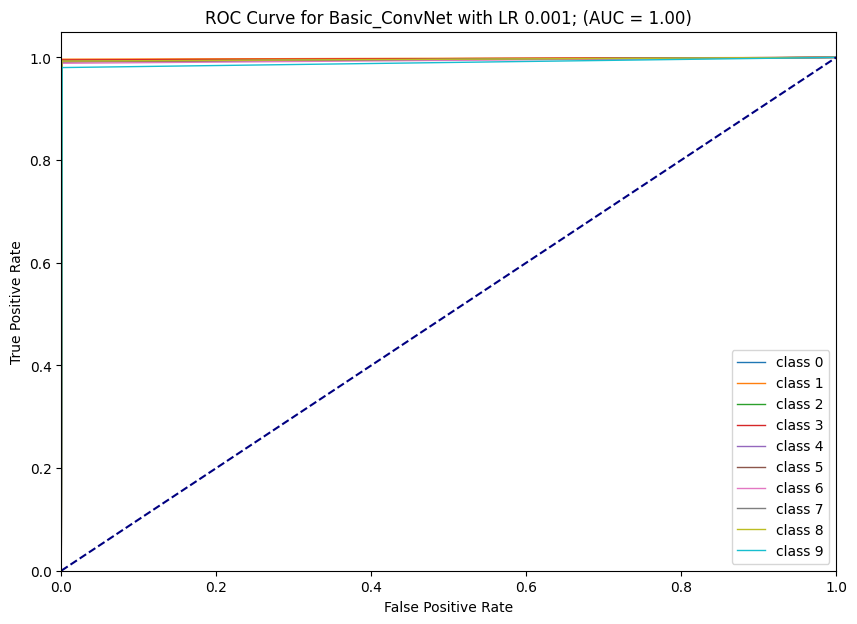

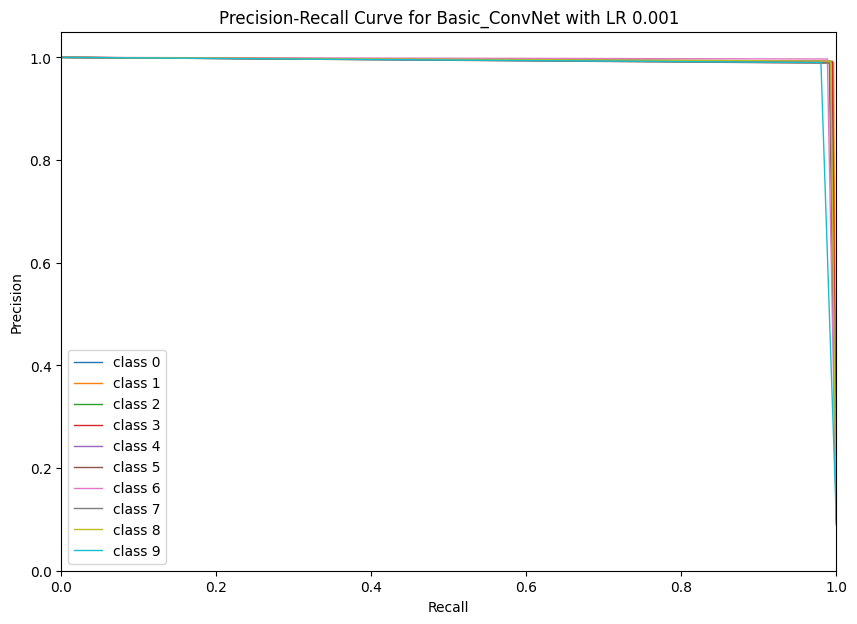


Training ResNet18

Learning Rate: 0.1
Epoch 1/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 70s 86ms/step - accuracy: 0.4133 - f1_score: 0.6714 - loss: 1.7755 - val_accuracy: 0.6995 - val_f1_score: 0.6812 - val_loss: 0.8591
Epoch 2/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 62s 83ms/step - accuracy: 0.8204 - f1_score: 0.8191 - loss: 0.5377 - val_accuracy: 0.6248 - val_f1_score: 0.6454 - val_loss: 1.3239
Epoch 3/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 61s 81ms/step - accuracy: 0.8824 - f1_score: 0.8820 - loss: 0.3682 - val_accuracy: 0.9088 - val_f1_score: 0.9086 - val_loss: 0.2977
Epoch 4/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 67s 90ms/step - accuracy: 0.9020 - f1_score: 0.9019 - loss: 0.3132 - val_accuracy: 0.7990 - val_f1_score: 0.7857 - val_loss: 0.6496
Epoch 5/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 68s 91ms/step - accuracy: 0.9093 - f1_score: 0.9092 - loss: 0.2877 - val_accuracy: 0.7425 - val_f1_score: 0.7284 - val_loss: 0.7869
Epoch 6/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 67s 90ms/step - accuracy: 0.9204 - f1_score: 0.9204 - loss: 0

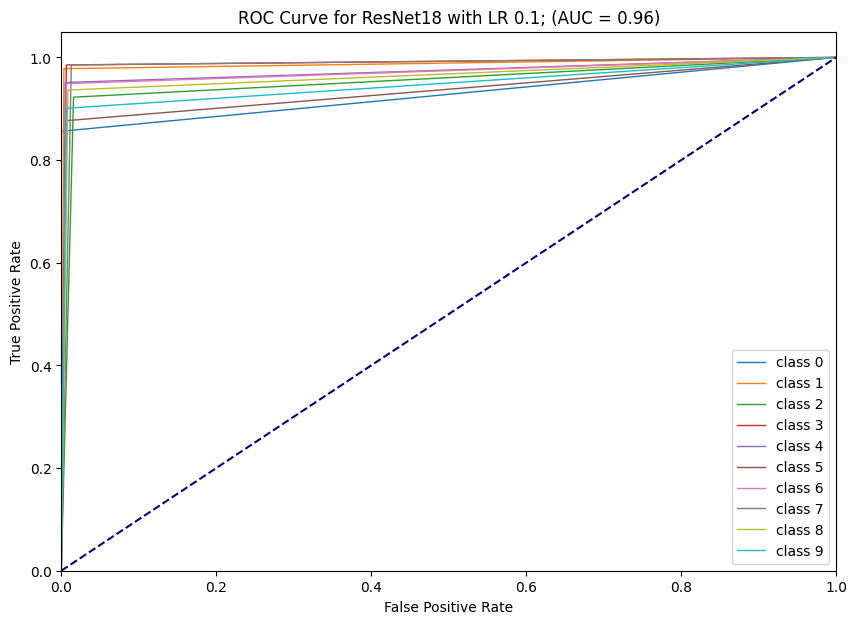

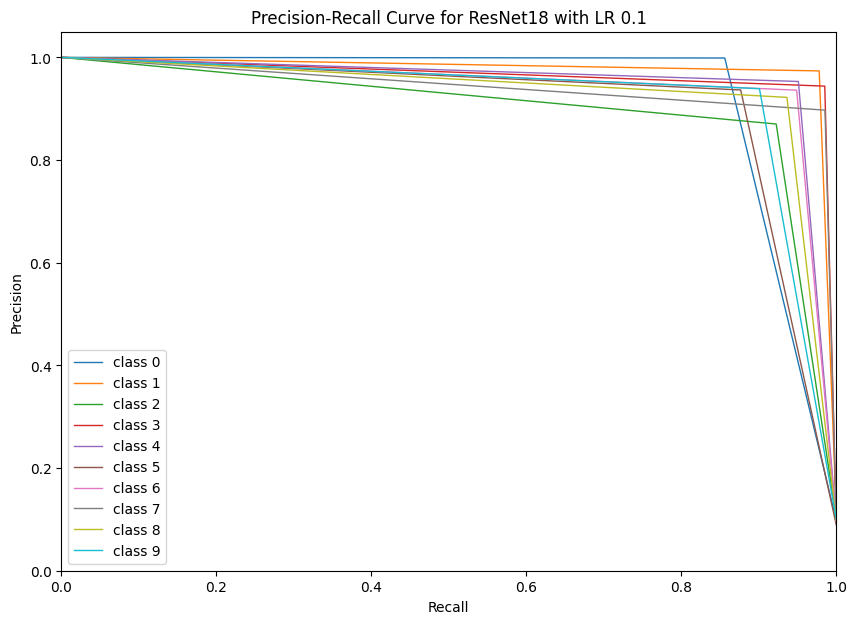


Learning Rate: 0.01
Epoch 1/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 73s 91ms/step - accuracy: 0.9529 - f1_score: 0.9427 - loss: 0.1577 - val_accuracy: 0.9538 - val_f1_score: 0.9538 - val_loss: 0.1551
Epoch 2/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 64s 86ms/step - accuracy: 0.9568 - f1_score: 0.9568 - loss: 0.1426 - val_accuracy: 0.9545 - val_f1_score: 0.9545 - val_loss: 0.1509
Epoch 3/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 66s 87ms/step - accuracy: 0.9577 - f1_score: 0.9577 - loss: 0.1380 - val_accuracy: 0.9558 - val_f1_score: 0.9558 - val_loss: 0.1470
Epoch 4/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 66s 88ms/step - accuracy: 0.9593 - f1_score: 0.9593 - loss: 0.1350 - val_accuracy: 0.9568 - val_f1_score: 0.9568 - val_loss: 0.1461
Epoch 5/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 67s 90ms/step - accuracy: 0.9601 - f1_score: 0.9601 - loss: 0.1326 - val_accuracy: 0.9571 - val_f1_score: 0.9571 - val_loss: 0.1445
Epoch 6/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 66s 88ms/step - accuracy: 0.9605 - f1_score: 0.9605 - loss: 0.1307 - val_accura

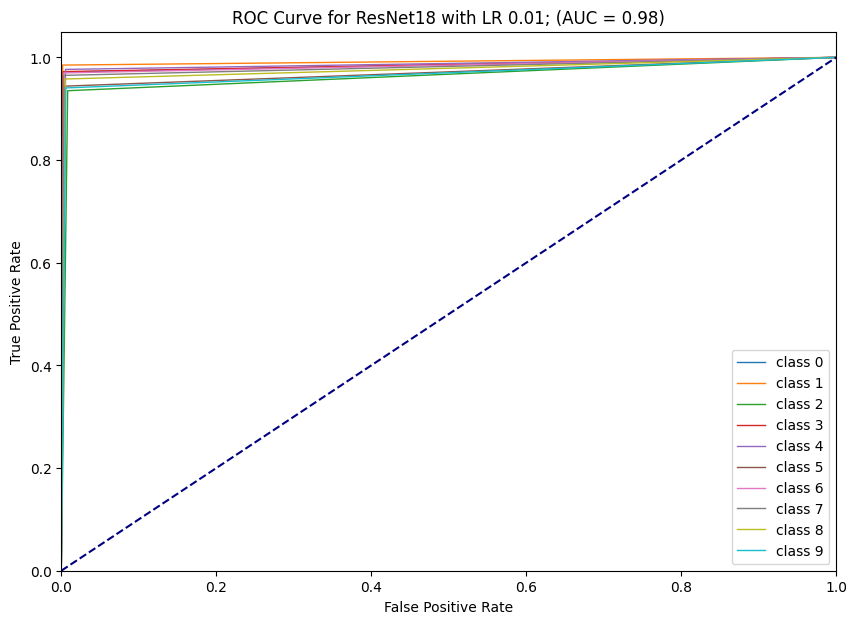

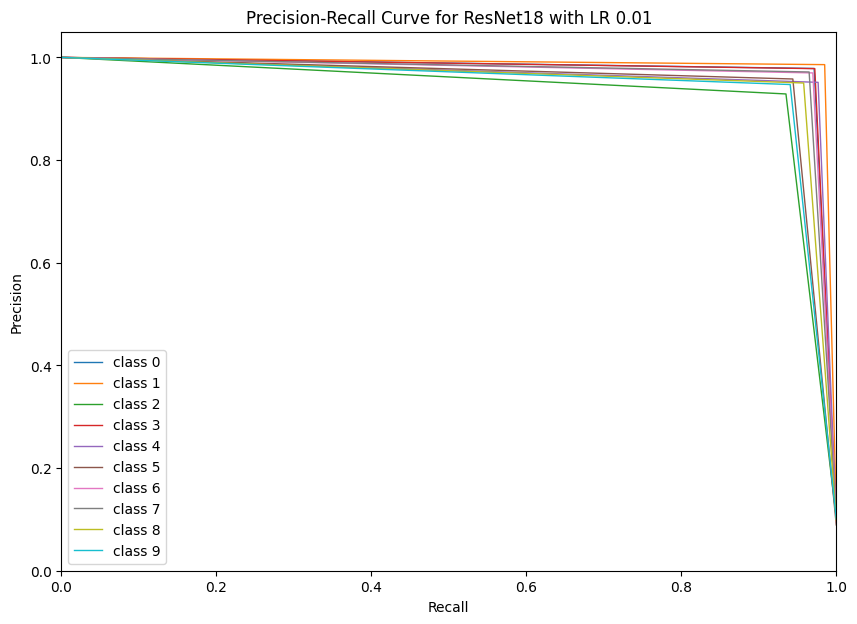


Learning Rate: 0.001
Epoch 1/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 74s 91ms/step - accuracy: 0.9646 - f1_score: 0.9614 - loss: 0.1166 - val_accuracy: 0.9597 - val_f1_score: 0.9598 - val_loss: 0.1347
Epoch 2/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 66s 88ms/step - accuracy: 0.9649 - f1_score: 0.9650 - loss: 0.1151 - val_accuracy: 0.9596 - val_f1_score: 0.9596 - val_loss: 0.1343
Epoch 3/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 65s 86ms/step - accuracy: 0.9652 - f1_score: 0.9652 - loss: 0.1145 - val_accuracy: 0.9599 - val_f1_score: 0.9599 - val_loss: 0.1340
Epoch 4/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 65s 86ms/step - accuracy: 0.9654 - f1_score: 0.9654 - loss: 0.1141 - val_accuracy: 0.9597 - val_f1_score: 0.9597 - val_loss: 0.1339
Epoch 5/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 62s 83ms/step - accuracy: 0.9654 - f1_score: 0.9654 - loss: 0.1138 - val_accuracy: 0.9598 - val_f1_score: 0.9598 - val_loss: 0.1338
Epoch 6/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 78s 104ms/step - accuracy: 0.9655 - f1_score: 0.9655 - loss: 0.1135 - val_accu

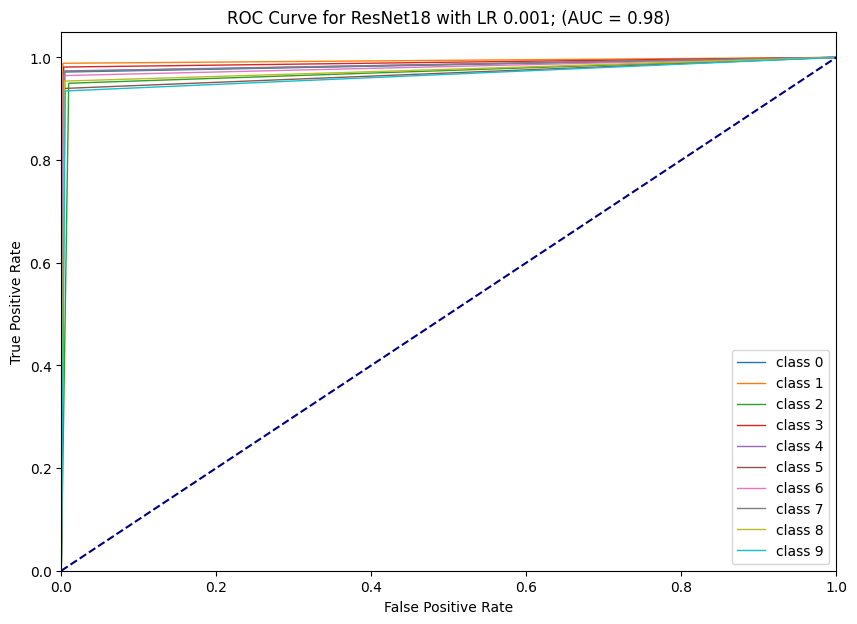

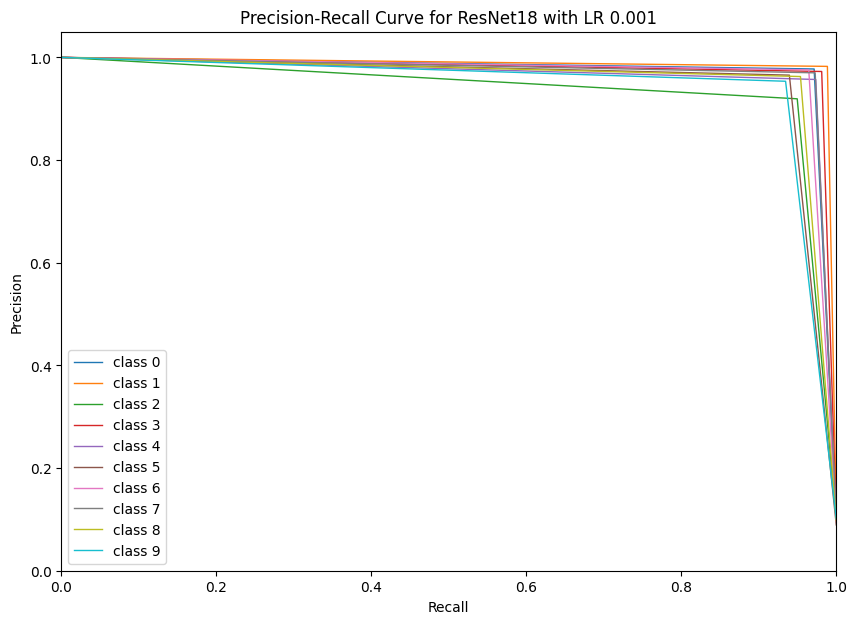


Training VGG_S

Learning Rate: 0.1
Epoch 1/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 91s 110ms/step - accuracy: 0.8106 - f1_score: 0.8855 - loss: 2.4248 - val_accuracy: 0.9482 - val_f1_score: 0.9482 - val_loss: 1.4221
Epoch 2/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 83s 110ms/step - accuracy: 0.9336 - f1_score: 0.9336 - loss: 1.8833 - val_accuracy: 0.9645 - val_f1_score: 0.9645 - val_loss: 1.9932
Epoch 3/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 87s 115ms/step - accuracy: 0.9438 - f1_score: 0.9438 - loss: 2.4257 - val_accuracy: 0.9523 - val_f1_score: 0.9526 - val_loss: 2.3145
Epoch 4/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 85s 114ms/step - accuracy: 0.9520 - f1_score: 0.9520 - loss: 3.0224 - val_accuracy: 0.9715 - val_f1_score: 0.9715 - val_loss: 2.4960
Epoch 5/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 81s 108ms/step - accuracy: 0.9641 - f1_score: 0.9641 - loss: 3.1375 - val_accuracy: 0.9813 - val_f1_score: 0.9813 - val_loss: 1.3383
Epoch 6/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 94s 126ms/step - accuracy: 0.9680 - f1_score: 0.9680 - loss

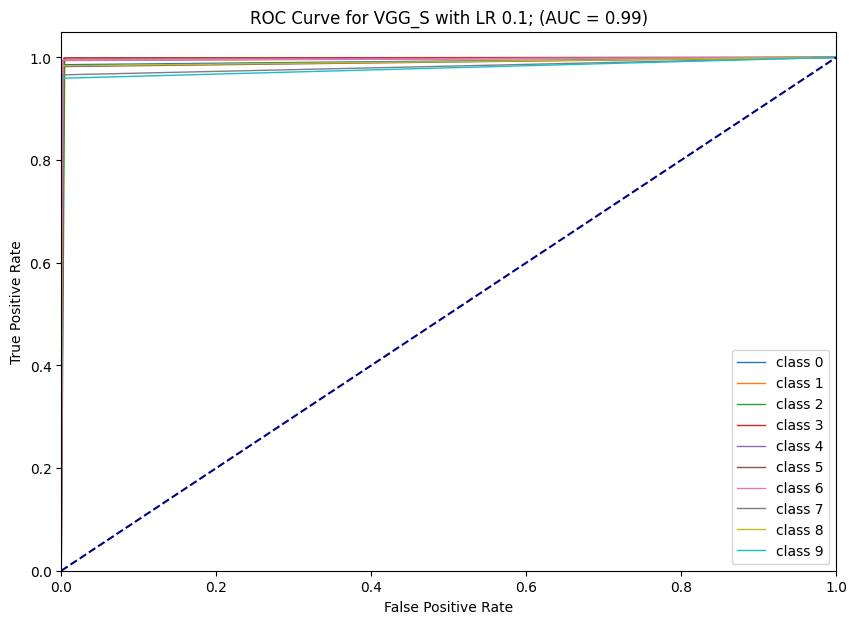

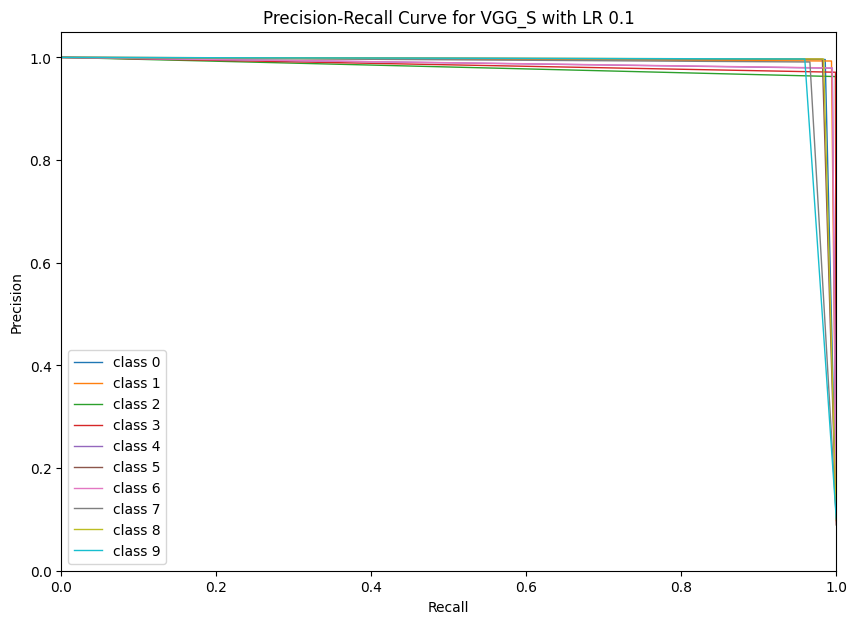


Learning Rate: 0.01
Epoch 1/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 91s 112ms/step - accuracy: 0.9846 - f1_score: 0.9851 - loss: 1.9141 - val_accuracy: 0.9931 - val_f1_score: 0.9931 - val_loss: 0.8409
Epoch 2/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 82s 110ms/step - accuracy: 0.9880 - f1_score: 0.9880 - loss: 1.1509 - val_accuracy: 0.9932 - val_f1_score: 0.9932 - val_loss: 0.5935
Epoch 3/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 144s 112ms/step - accuracy: 0.9889 - f1_score: 0.9889 - loss: 0.7679 - val_accuracy: 0.9940 - val_f1_score: 0.9940 - val_loss: 0.5374
Epoch 4/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 141s 111ms/step - accuracy: 0.9901 - f1_score: 0.9901 - loss: 0.6437 - val_accuracy: 0.9938 - val_f1_score: 0.9938 - val_loss: 0.4778
Epoch 5/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 86s 114ms/step - accuracy: 0.9894 - f1_score: 0.9894 - loss: 0.5014 - val_accuracy: 0.9936 - val_f1_score: 0.9936 - val_loss: 0.3333
Epoch 6/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 82s 110ms/step - accuracy: 0.9894 - f1_score: 0.9894 - loss: 0.4054 - va

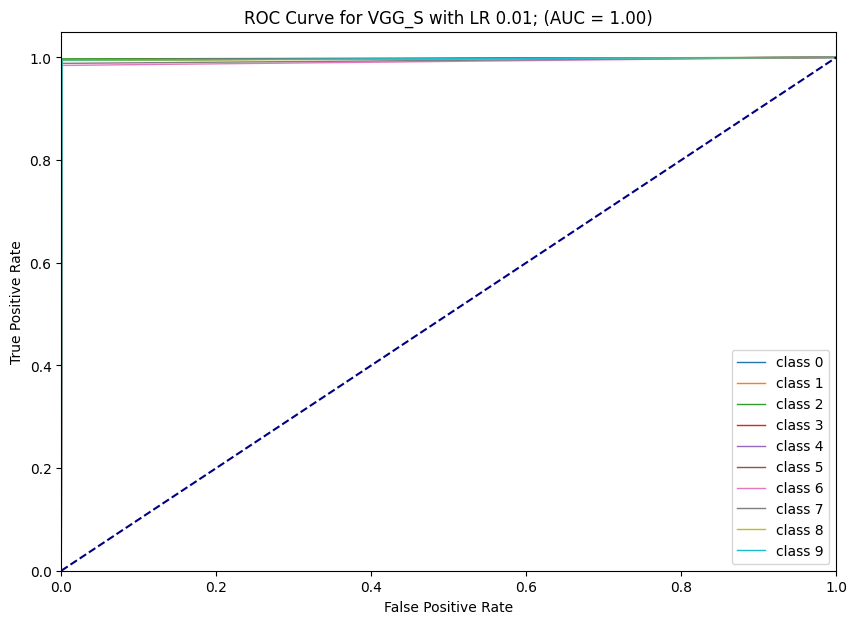

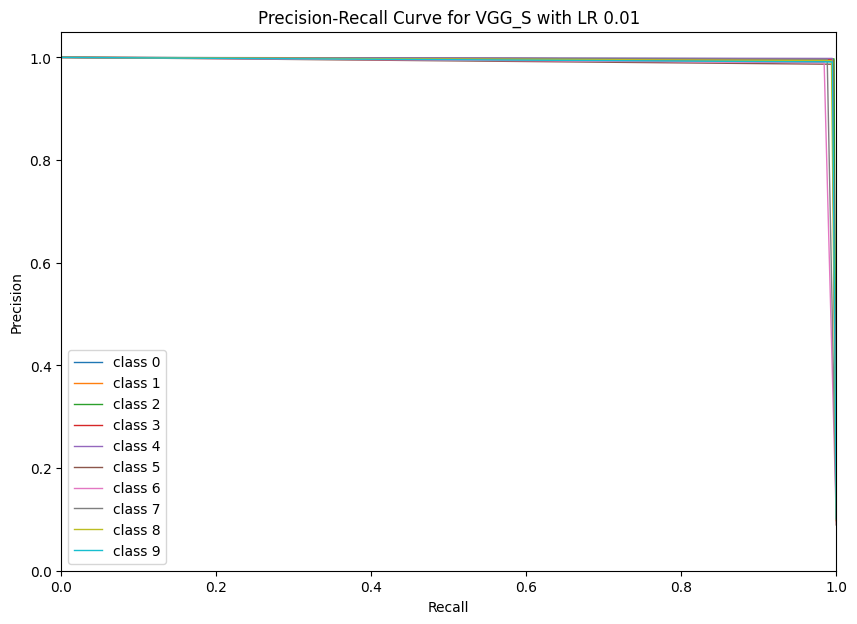


Learning Rate: 0.001
Epoch 1/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 94s 112ms/step - accuracy: 0.9935 - f1_score: 0.9937 - loss: 0.1528 - val_accuracy: 0.9941 - val_f1_score: 0.9941 - val_loss: 3.8403
Epoch 2/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 87s 116ms/step - accuracy: 0.9929 - f1_score: 0.9929 - loss: 0.1506 - val_accuracy: 0.9937 - val_f1_score: 0.9937 - val_loss: 1.6253
Epoch 3/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 84s 112ms/step - accuracy: 0.9928 - f1_score: 0.9928 - loss: 0.1518 - val_accuracy: 0.9936 - val_f1_score: 0.9936 - val_loss: 20.6474
Epoch 4/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 85s 114ms/step - accuracy: 0.9921 - f1_score: 0.9921 - loss: 0.1346 - val_accuracy: 0.9936 - val_f1_score: 0.9936 - val_loss: 25.2582
Epoch 5/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 84s 112ms/step - accuracy: 0.9922 - f1_score: 0.9922 - loss: 0.1502 - val_accuracy: 0.9937 - val_f1_score: 0.9937 - val_loss: 4.2861
Epoch 6/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 84s 112ms/step - accuracy: 0.9936 - f1_score: 0.9936 - loss: 0.1278 - v

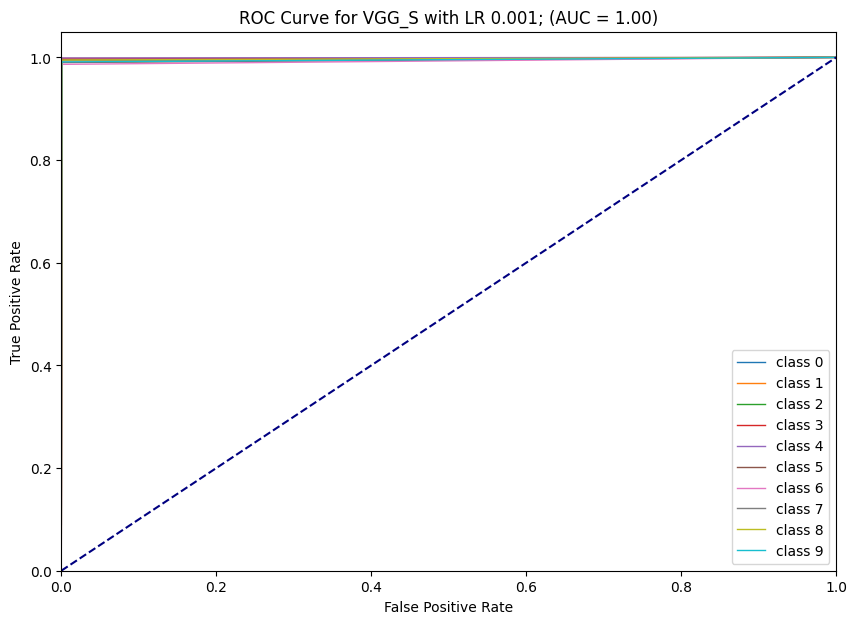

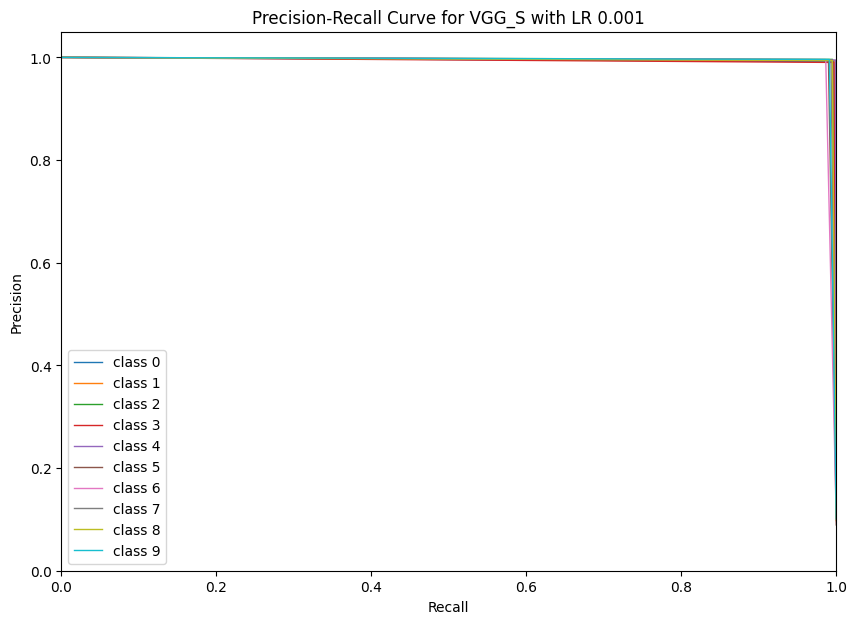

In [128]:
x_train, y_train, x_val, y_val, x_test, y_test = load_preprocess_data()

input_shape = (28,28,1)
num_classes = 10

# Main training
# Define models
models_dict = {
    'Basic_DNN': build_basic_dnn(input_shape, num_classes),
    'Basic_ConvNet': build_basic_convnet(input_shape, num_classes),
    'ResNet18': build_resnet18(input_shape, num_classes),
    'VGG_S': build_vgg_s(input_shape, num_classes)
}

# Define learning rates
learning_rates = [0.1, 0.01, 0.001]

# Dictionaries to store metrics
history_dict = defaultdict(dict)
roc_auc_dict = defaultdict(dict)
pr_auc_dict = defaultdict(dict)

for model_name, model in models_dict.items():
    print(f'\n{"="*50}\nTraining {model_name}\n{"="*50}')
    for lr in learning_rates:
        print(f'\nLearning Rate: {lr}')
        # Compile model
        optimizer = optimizers.Adam(learning_rate=lr)
        model.compile(optimizer=optimizer,
                      loss='categorical_crossentropy',
                      metrics=['accuracy',f1_metric])

        # Train model
        history = model.fit(x_train, y_train,
                            epochs=10,
                            batch_size=64,
                            validation_data=(x_val, y_val),
                            callbacks=[EarlyStopping(patience=5, monitor='f1_score')],
                            verbose=1)

        # Save metrics
        history_dict[model_name][lr] = {
            'accuracy': history.history['accuracy'],
            'val_accuracy': history.history['val_accuracy'],
            'loss': history.history['loss'],
            'val_loss': history.history['val_loss'],
            'f1_score': history.history['f1_score'],
            'val_f1_score': history.history['val_f1_score']
        }

        # Save model weights
        path = f'trained_models/{model_name}_lr_{lr}.keras'
        model.save(path)
        print(f'Model saved to {path}')
        
        y_pred_proba = model.predict(x_test)
        y_pred = (y_pred_proba == y_pred_proba.max(axis=1)[:,None]).astype(int)
        # Plot combined ROC curves
        plot_combined_roc(y_test, y_pred, model_name, lr)

        # Plot combined Precision-Recall curves
        plot_combined_precision_recall(y_test, y_pred, model_name, lr)

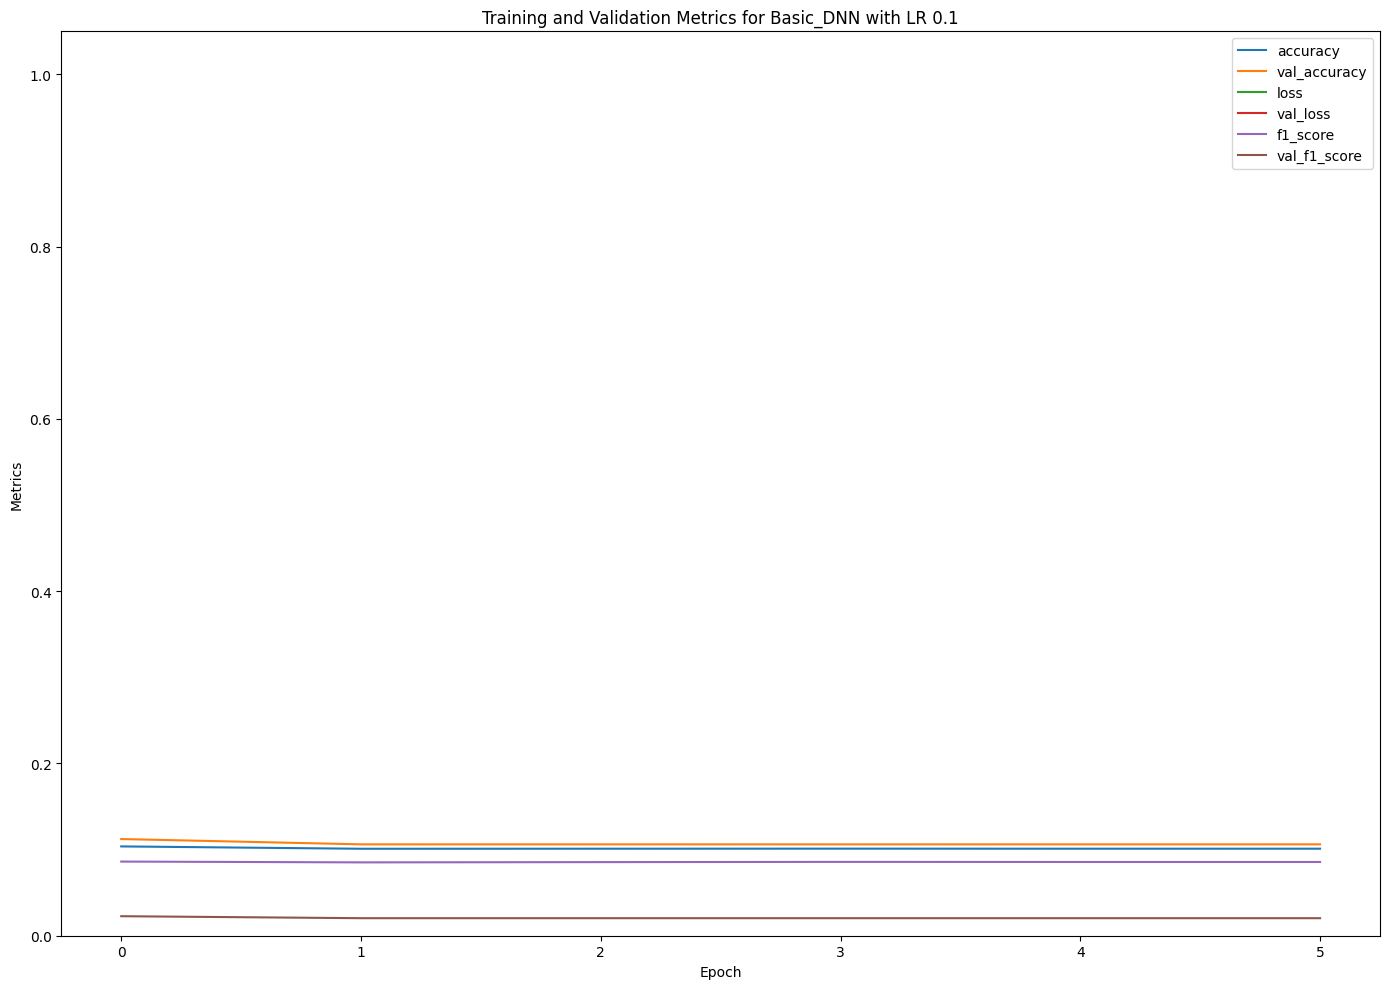

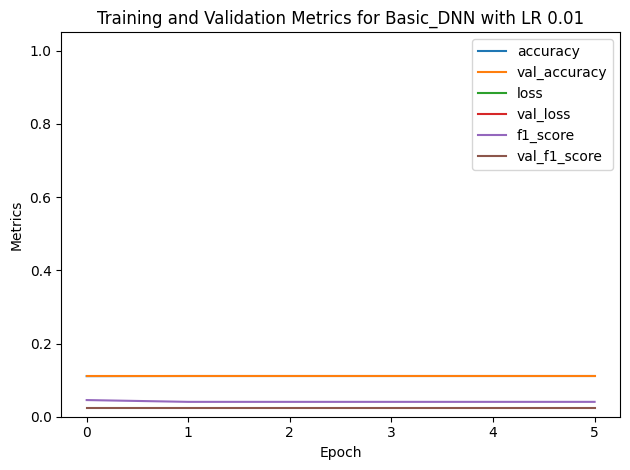

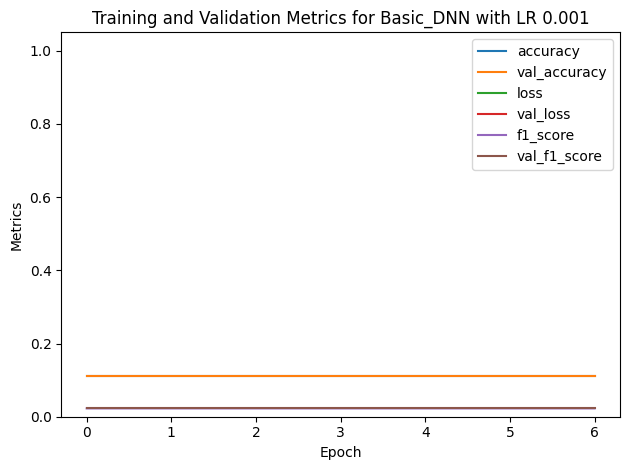

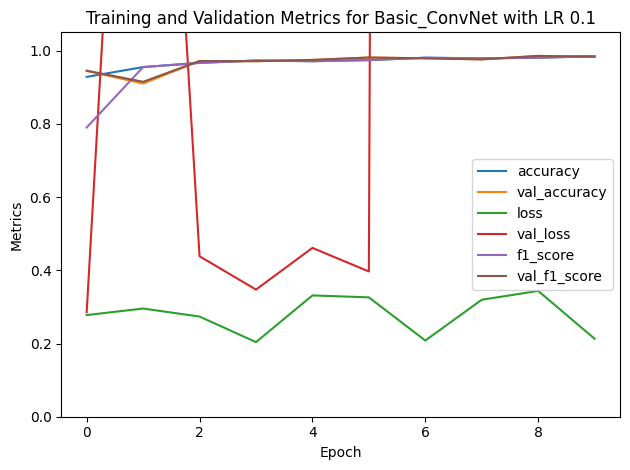

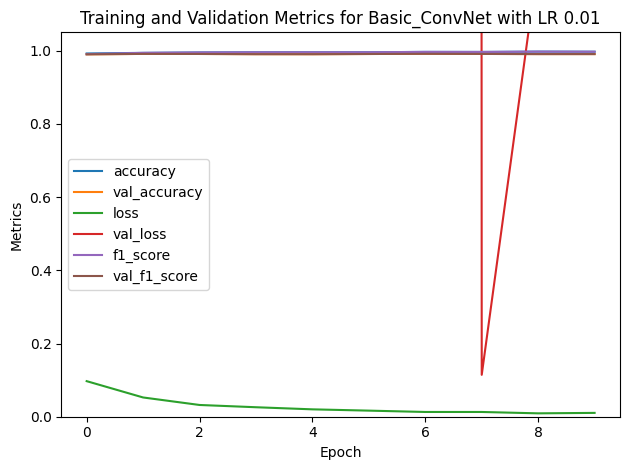

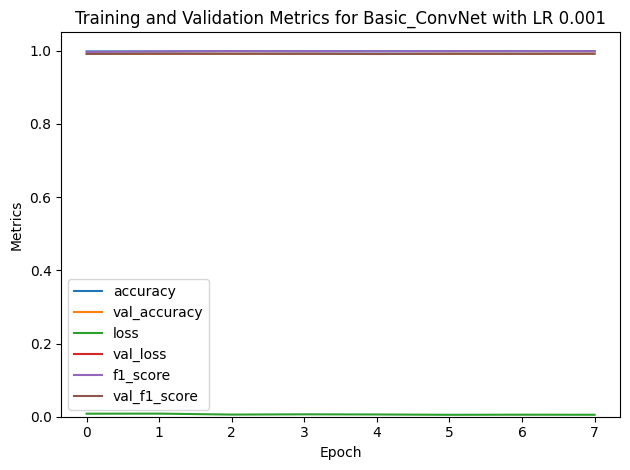

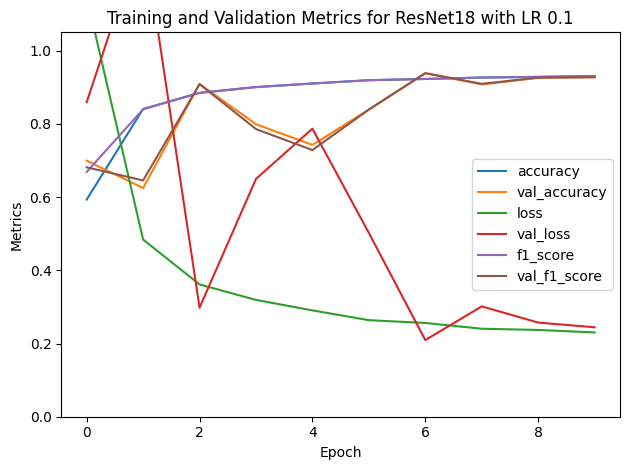

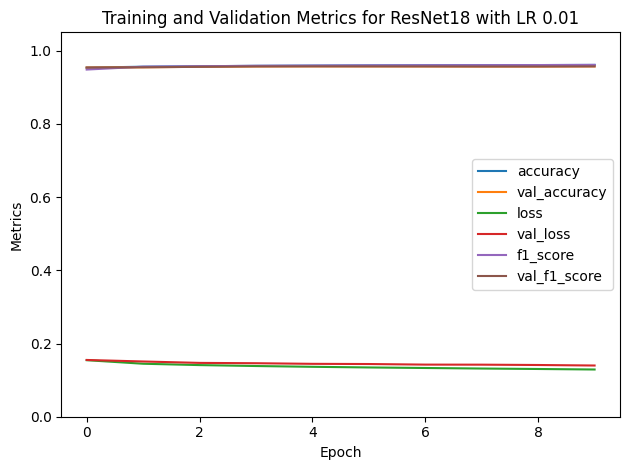

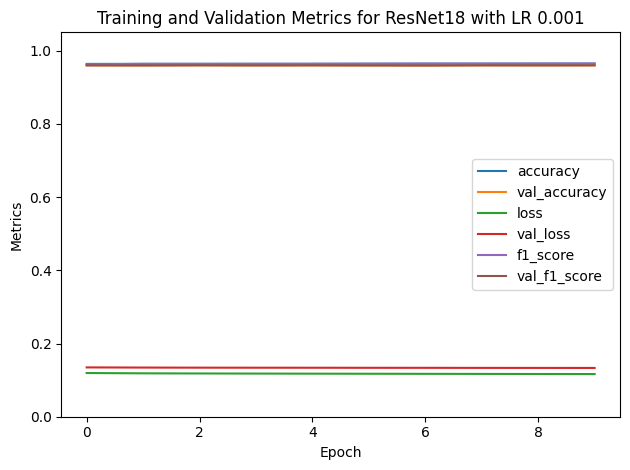

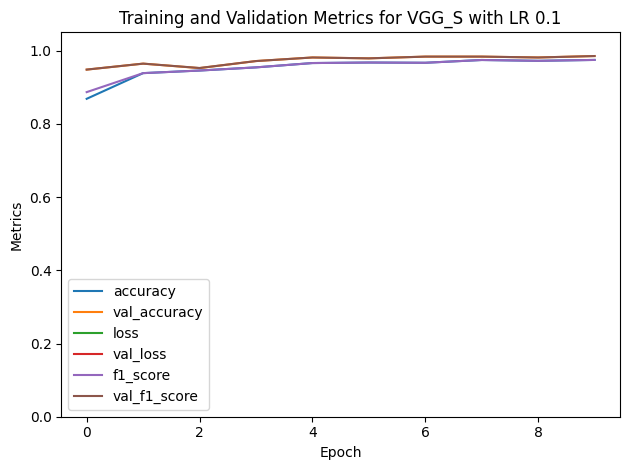

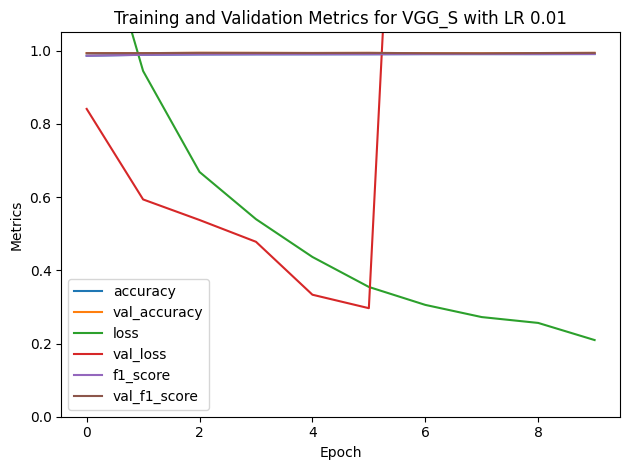

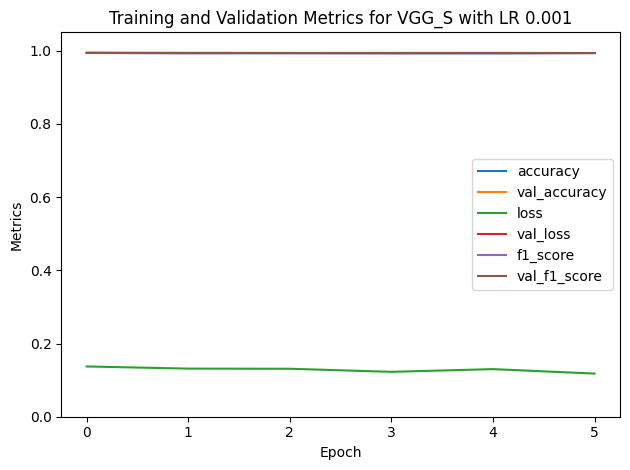

In [129]:
# Plot Accuracy, Loss, F1 Score
plot_accuracies(history_dict)

375/375 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step


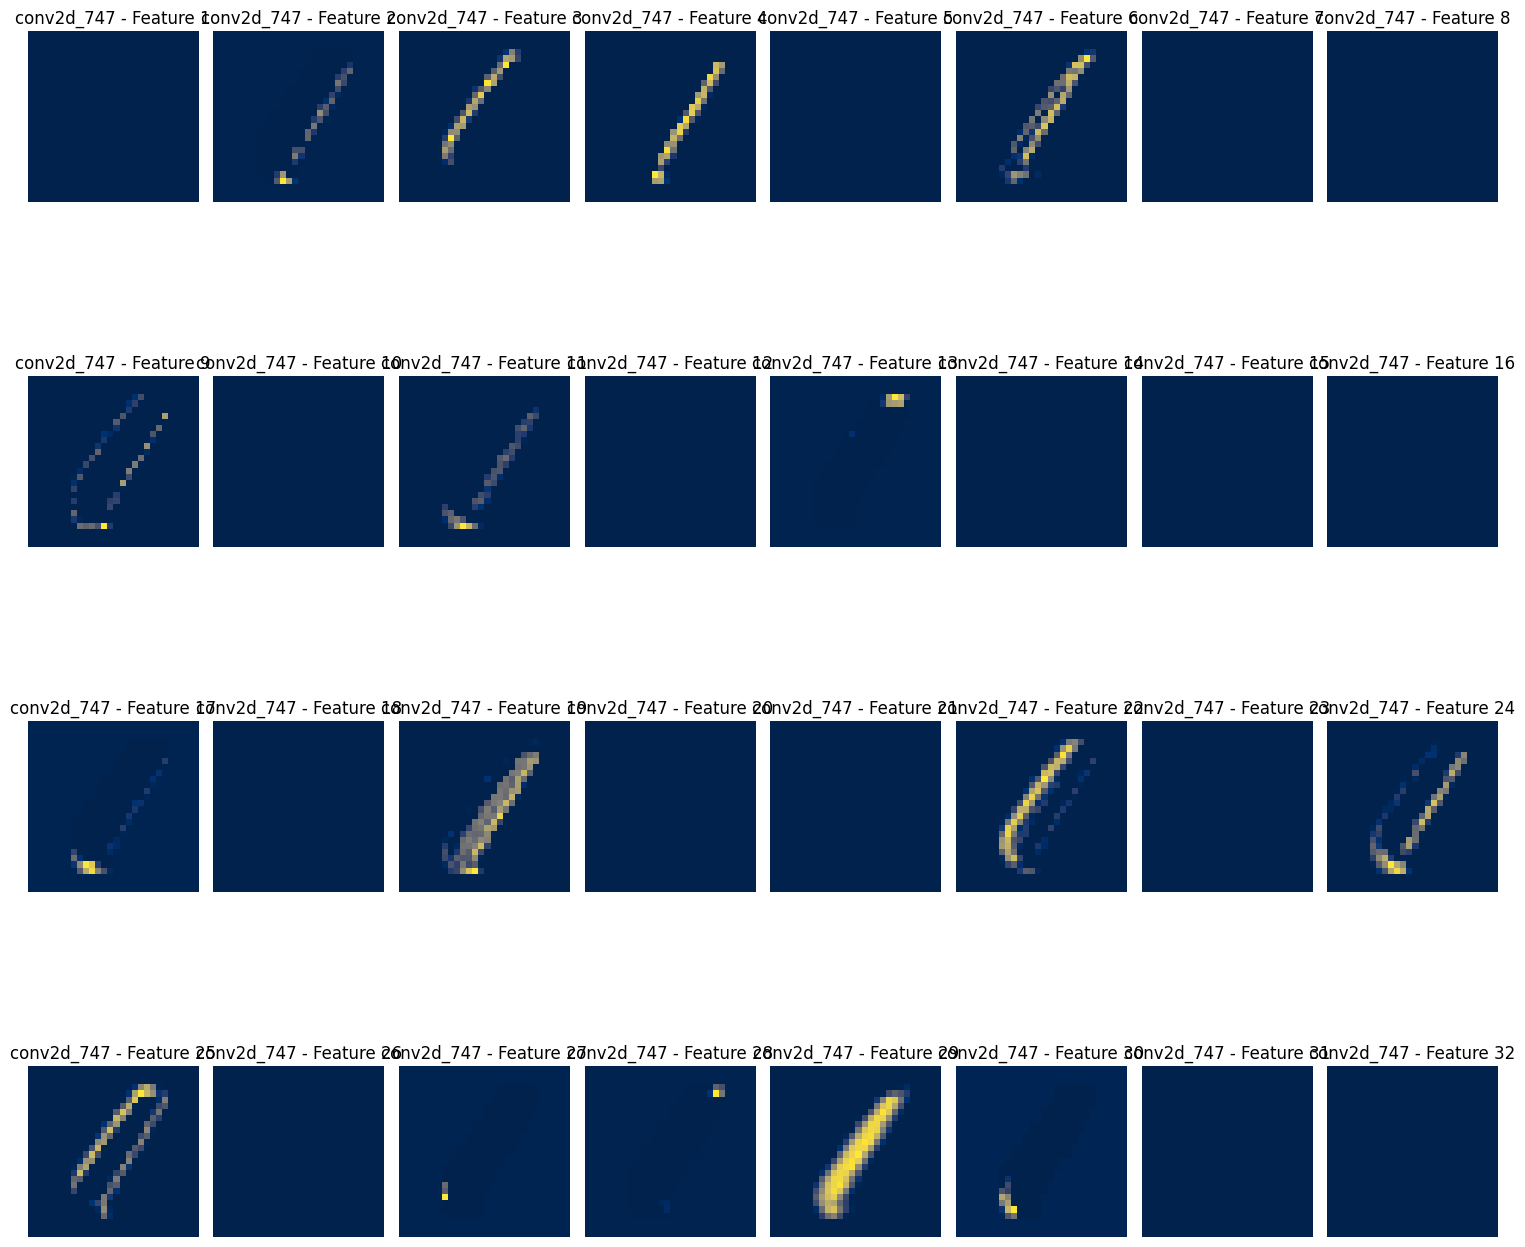

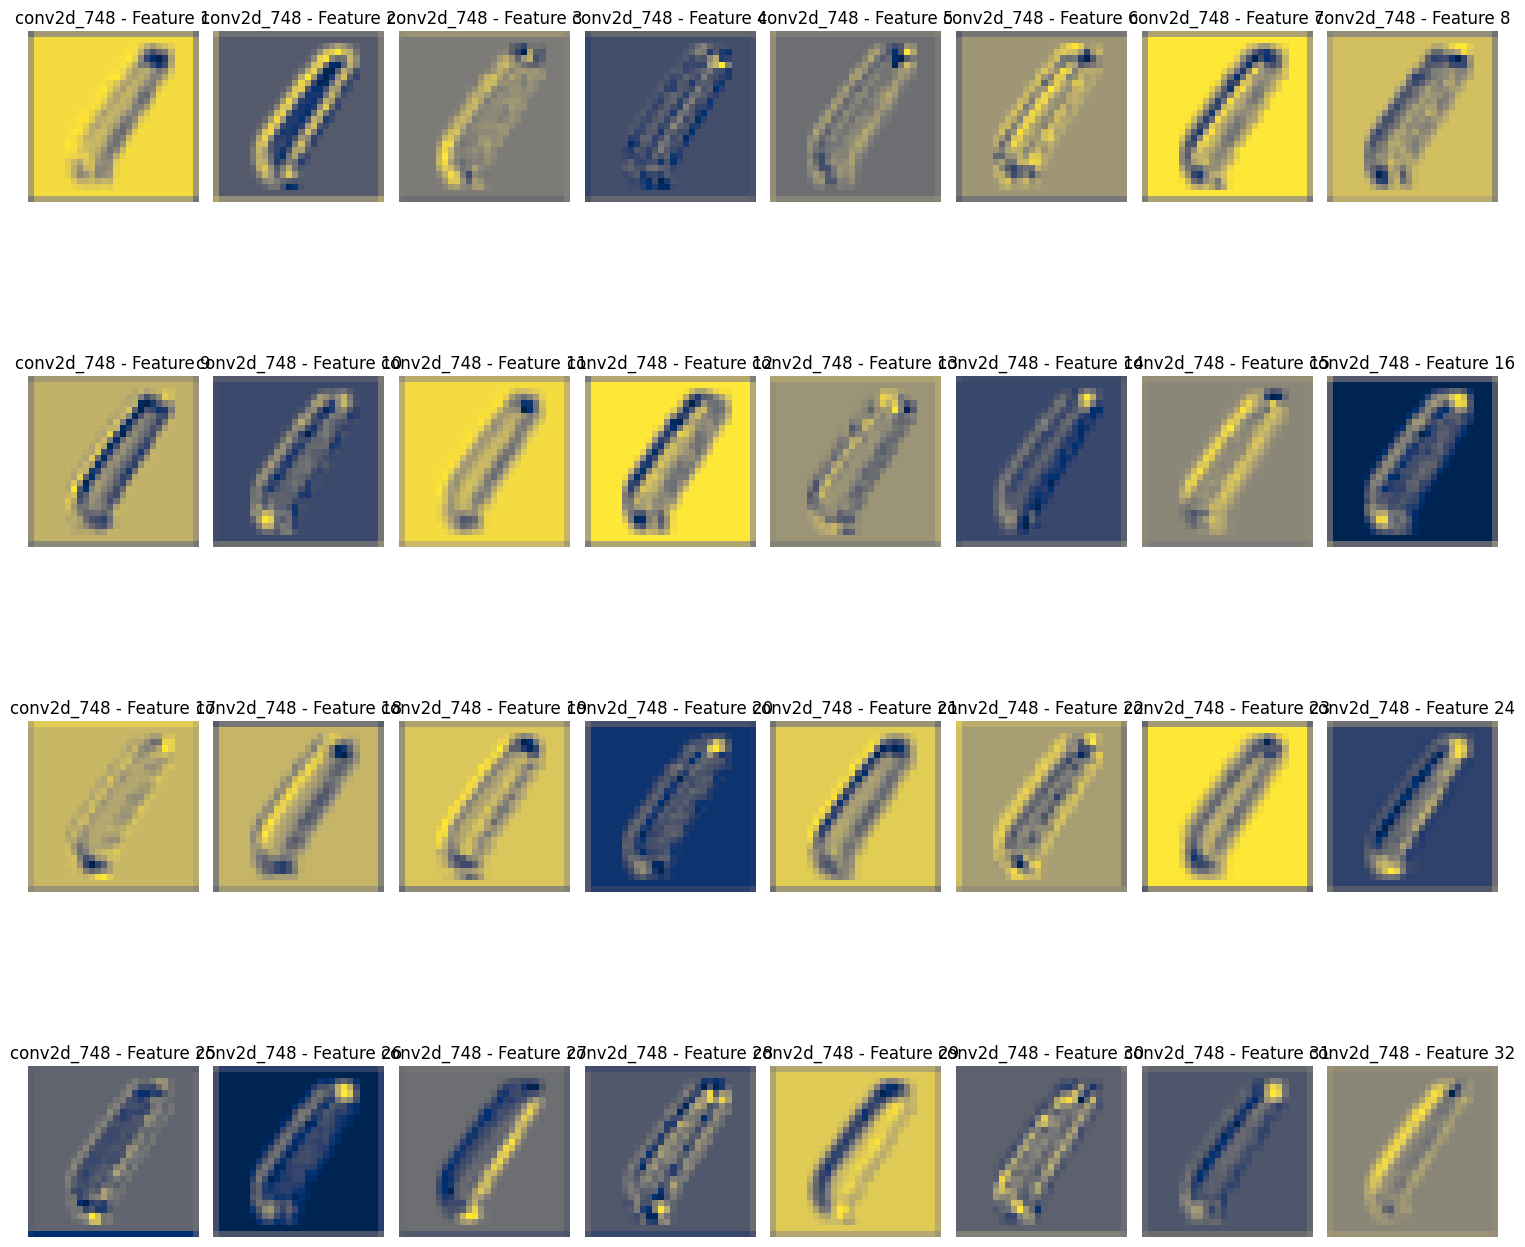

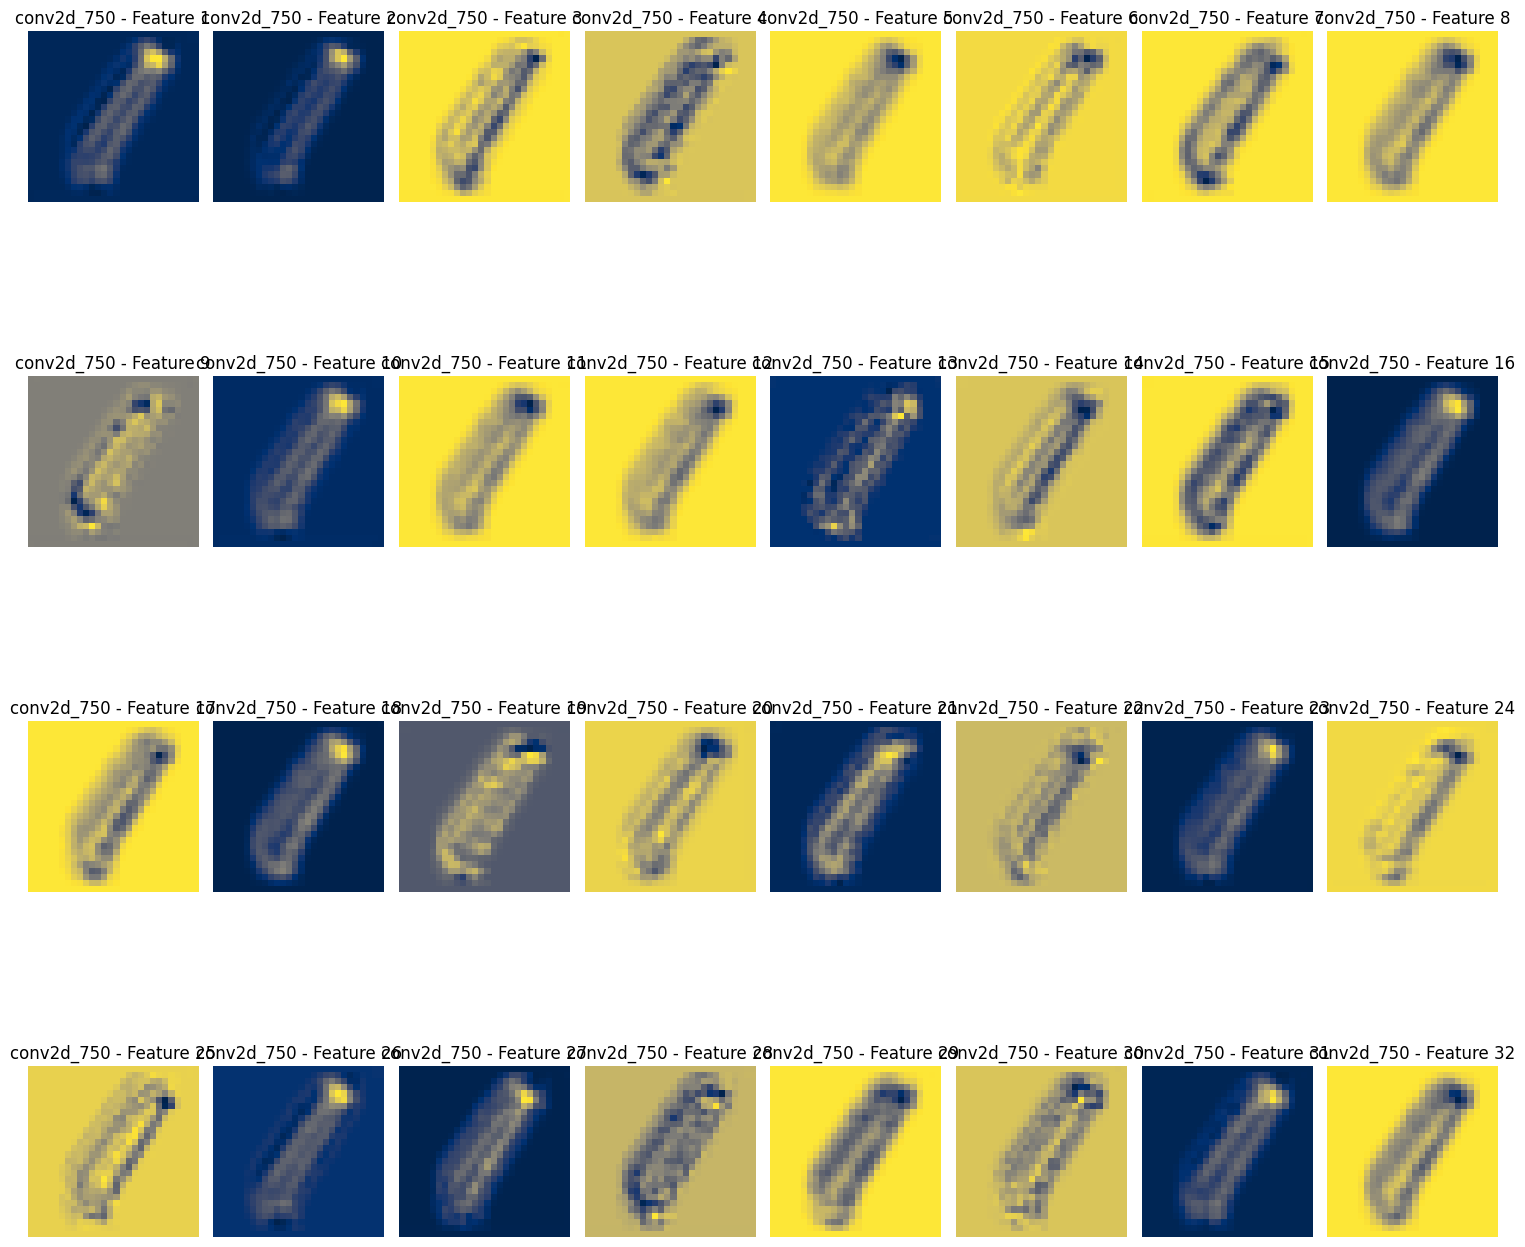

In [134]:
#Feature Visualise for Best Model
model = models.load_model('trained_models/VGG_S_lr_0.001.keras')
layer_visualise(model)

In [8]:
#Test the model predictions by inputting new samples
#Note: Execute the first and top most cell containing import statements before running this celll
def test_model_pred(input_image):
    model = models.load_model('trained_models/ResNet18_lr_0.001.keras')
    pred = model.predict([input_image])
    prediction = np.argmax(pred)
    return prediction